In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [3]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

oil_tickers_names = {'CL=F':'Crude Oil',
                     'NG=F':'Natural Gas'}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
for symbol, name in oil_tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('stock_data.csv', index = False)


# Inspect Data

## General

In [4]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   6375 non-null   object        
 1   company  6375 non-null   object        
 2   date     6375 non-null   datetime64[ns]
 3   open     6375 non-null   float64       
 4   high     6375 non-null   float64       
 5   low      6375 non-null   float64       
 6   close    6375 non-null   float64       
 7   volume   6375 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 398.6+ KB
None


In [5]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           6375  6375.000000  6375.000000  6375.000000   
mean   2023-02-12 00:46:59.011764480    64.247392    64.981397    63.490582   
min              2021-01-04 00:00:00     1.533000     1.628000     1.481000   
25%              2022-01-21 00:00:00    30.286714    30.527573    30.062460   
50%              2023-02-13 00:00:00    61.430116    61.840000    60.866519   
75%              2024-03-05 00:00:00    93.679387    95.001032    92.411638   
max              2025-03-26 00:00:00   169.405654   171.723328   168.554666   
std                              NaN    45.127787    45.594384    44.634695   

             close        volume  
count  6375.000000  6.375000e+03  
mean     64.245181  7.687502e+06  
min       1.575000  0.000000e+00  
25%      30.324041  3.321445e+05  
50%      61.418663  5.904500e+06  
75%      93.670002  1.123805e+07  
ma

In [6]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Natural Gas    1064
Crude Oil      1063
ExxonMobil     1062
Shell          1062
Chevron        1062
BP             1062
Name: count, dtype: int64


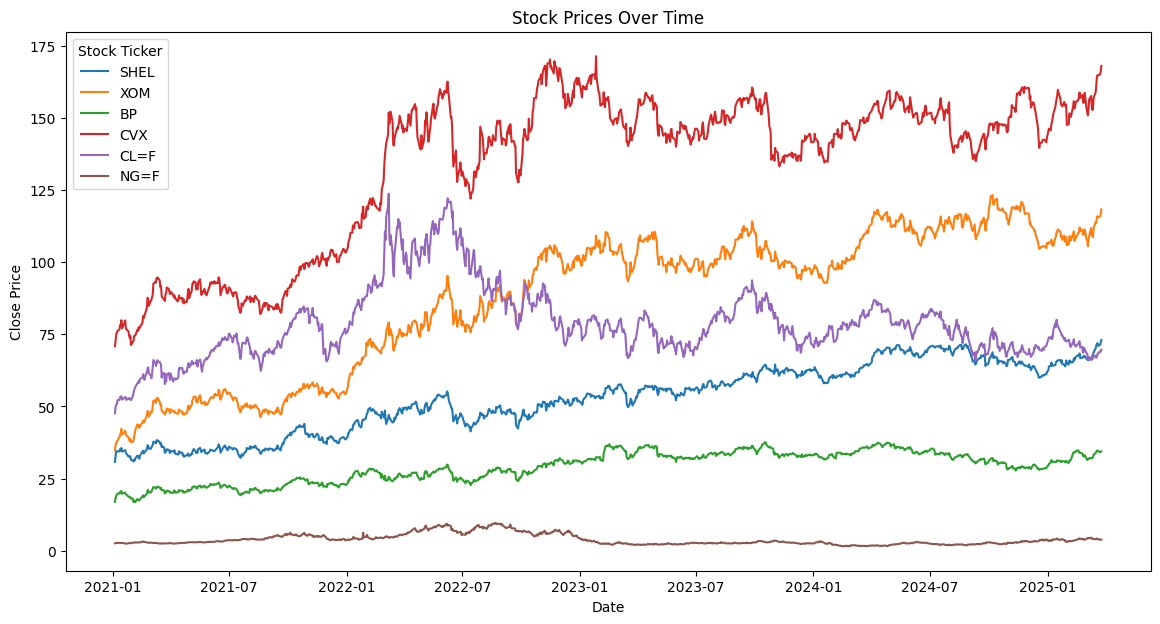

In [7]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.show()

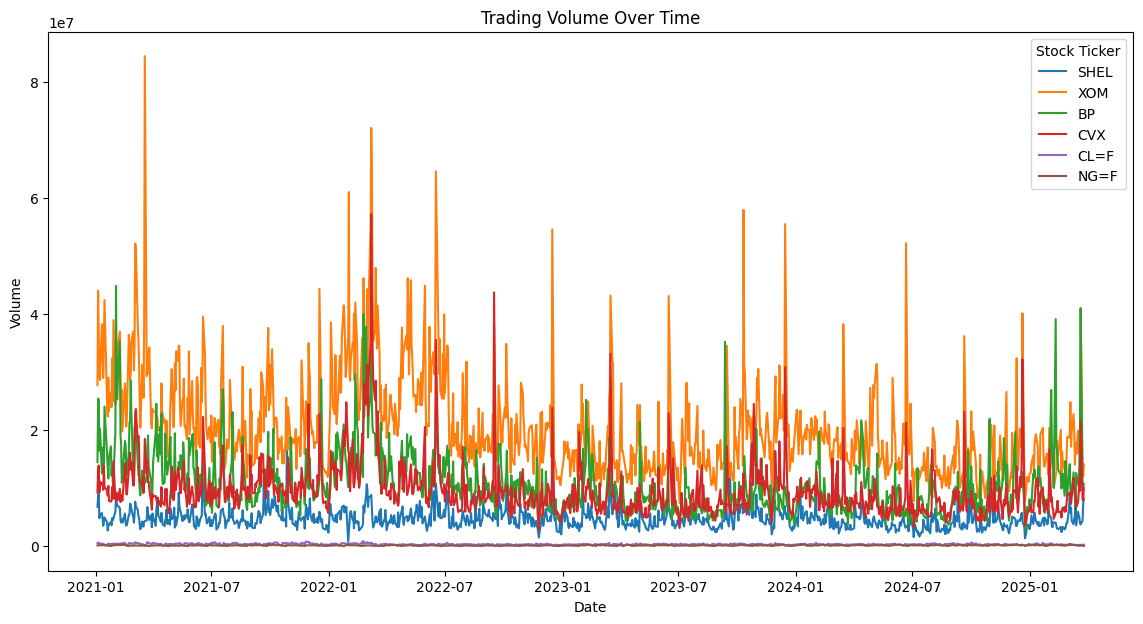

In [8]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.show()

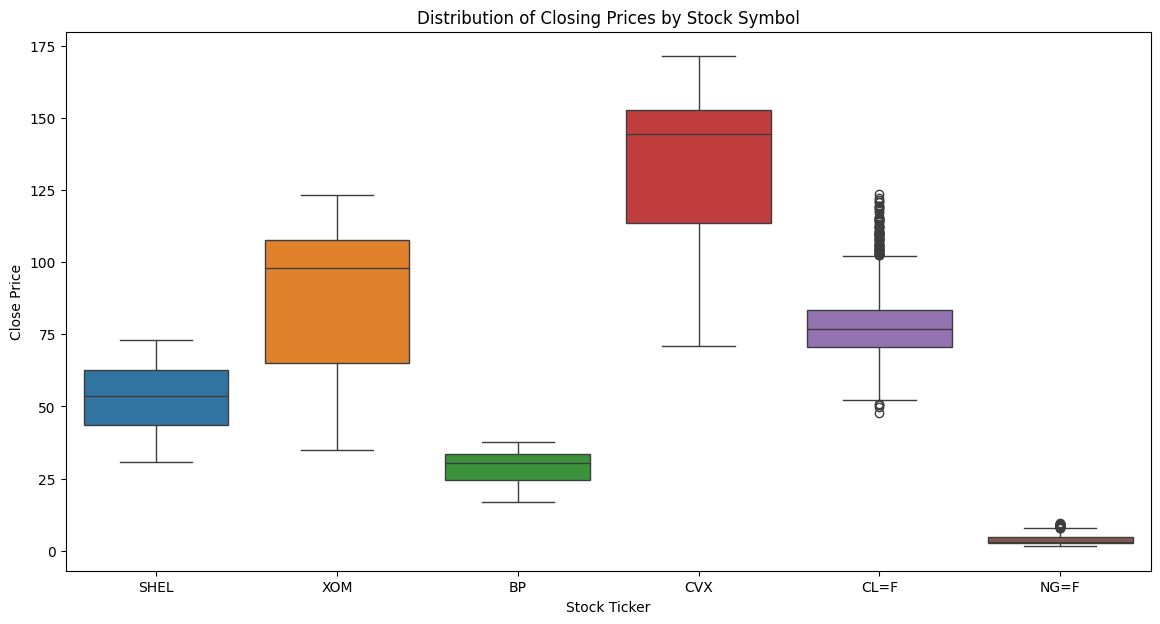

In [9]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.show()

In [10]:
# pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
# pivot_table

pivot_table = stock_data.reset_index().pivot(index='date', columns='ticker', values='close')
pivot_table


ticker             BP       CL=F         CVX   NG=F       SHEL         XOM
date                                                                      
2021-01-04  16.946371  47.619999   70.881592  2.581  30.810038   34.851486
2021-01-05  18.207380  49.930000   72.797768  2.702  32.930748   36.531078
2021-01-06  19.045347  50.630001   75.140686  2.716  34.452854   37.463242
2021-01-07  19.452124  50.830002   75.492119  2.729  34.495613   37.757179
2021-01-08  19.850771  52.240002   76.211716  2.700  34.410095   38.177074
...               ...        ...         ...    ...        ...         ...
2025-03-20  34.750000  68.260002  164.770004  3.975  71.949997  115.900002
2025-03-21  34.549999  68.279999  164.750000  3.980  71.010002  115.500000
2025-03-24  34.110001  69.110001  165.020004  3.914  71.279999  115.800003
2025-03-25  34.290001  69.000000  165.940002  3.840  72.029999  116.589996
2025-03-26  34.419998  69.650002  167.970001  3.861  73.029999  118.269997

[1064 rows x 6 columns]

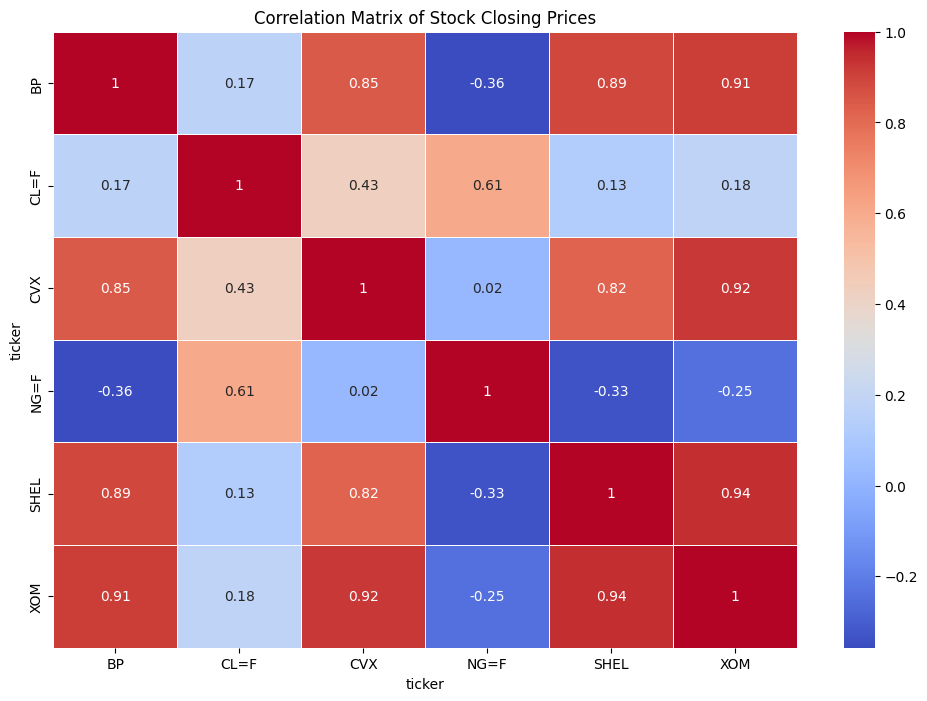

In [11]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.show()

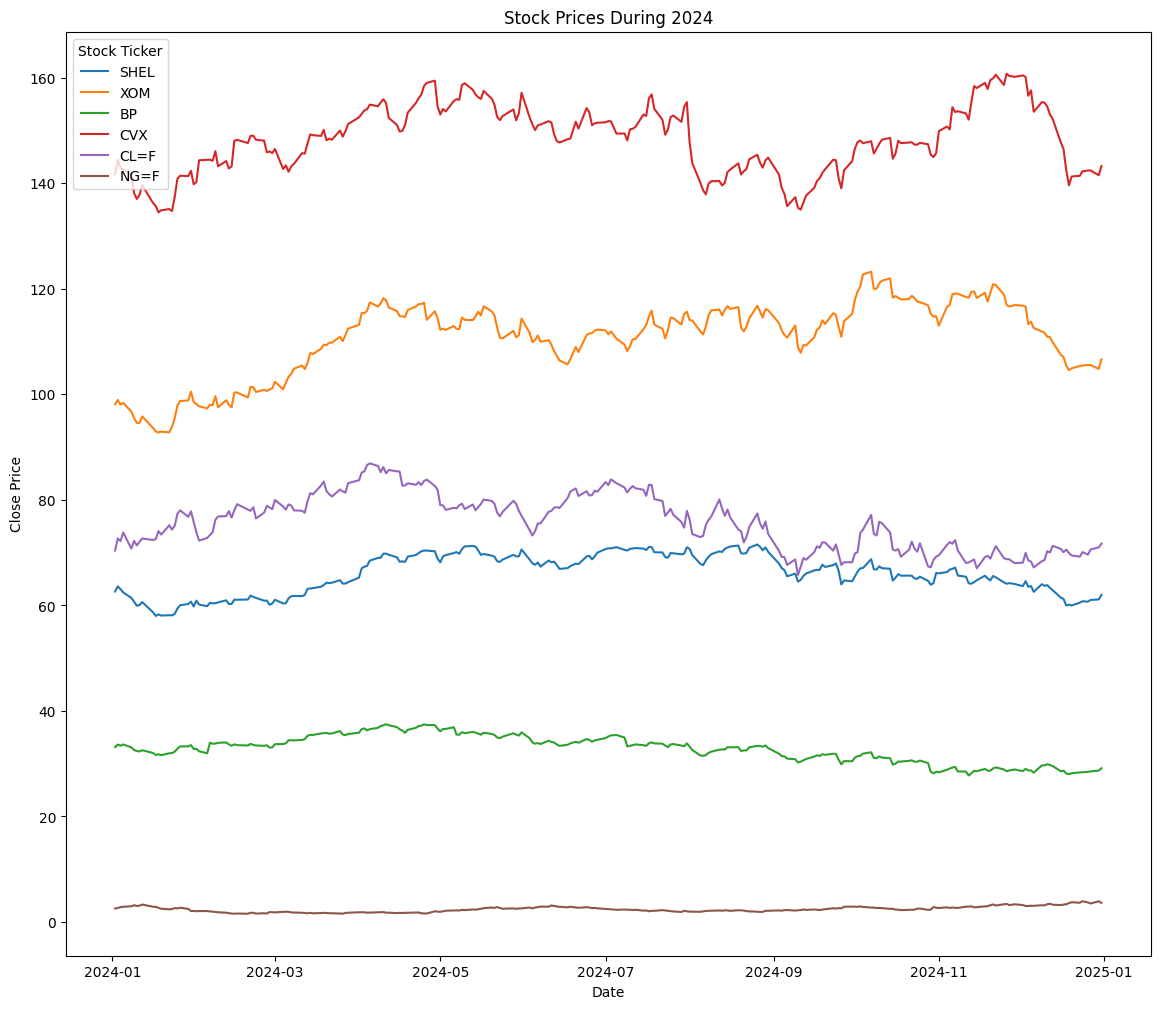

In [12]:
stock_data_2024 = stock_data.reset_index()[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.show()

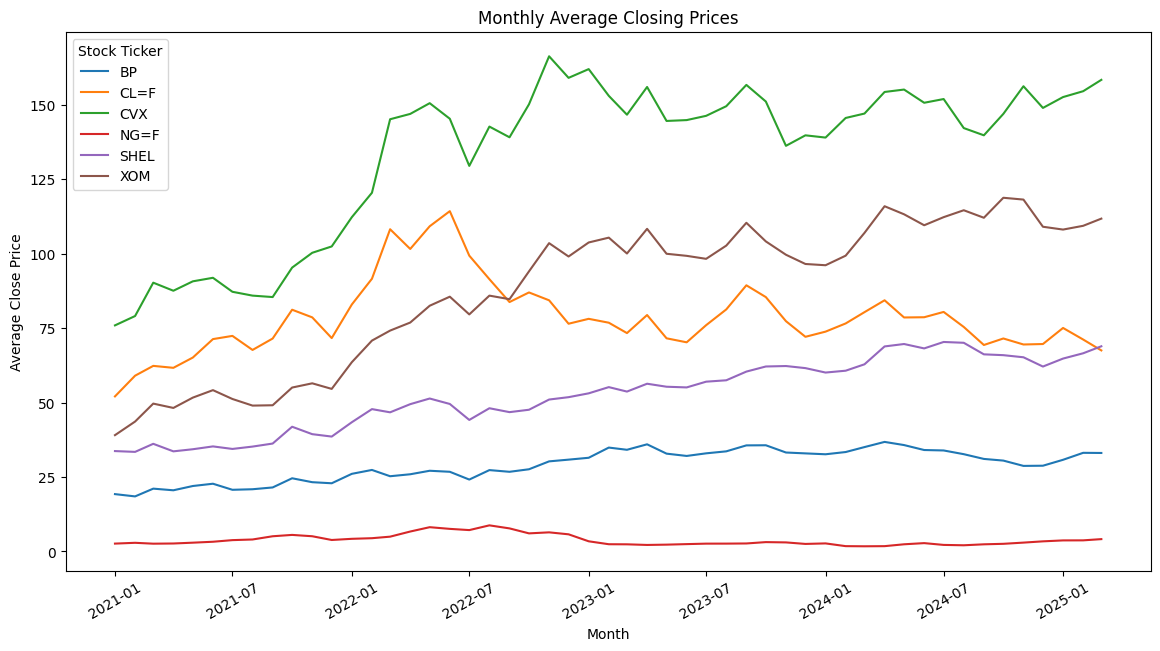

In [13]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.show()

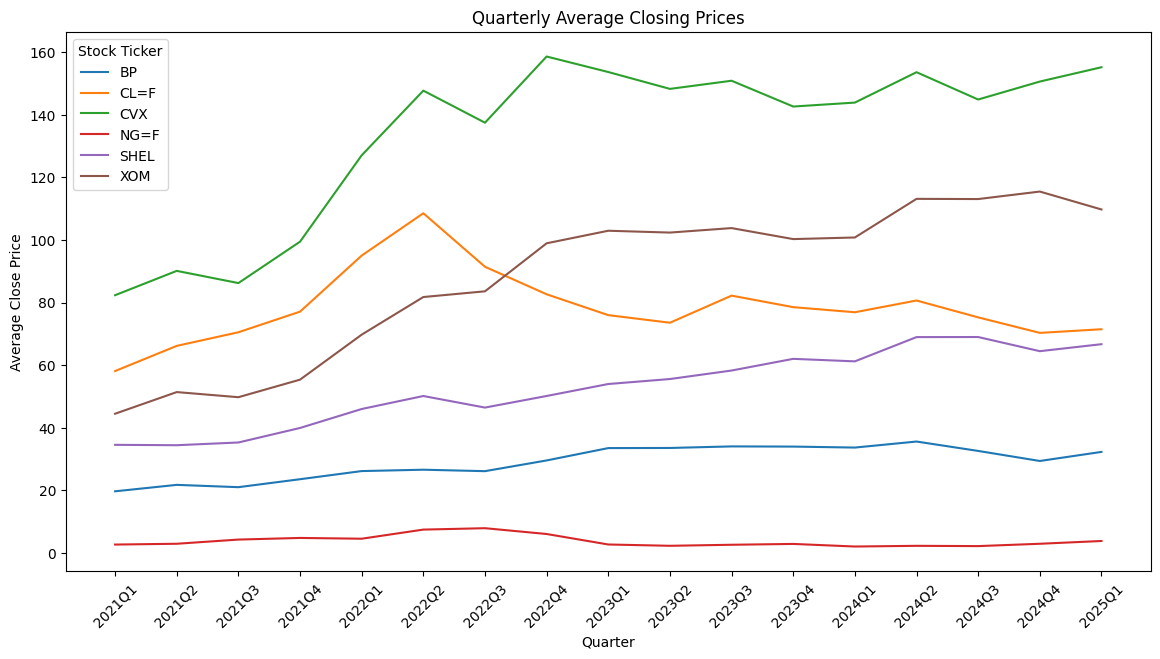

In [14]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.show()

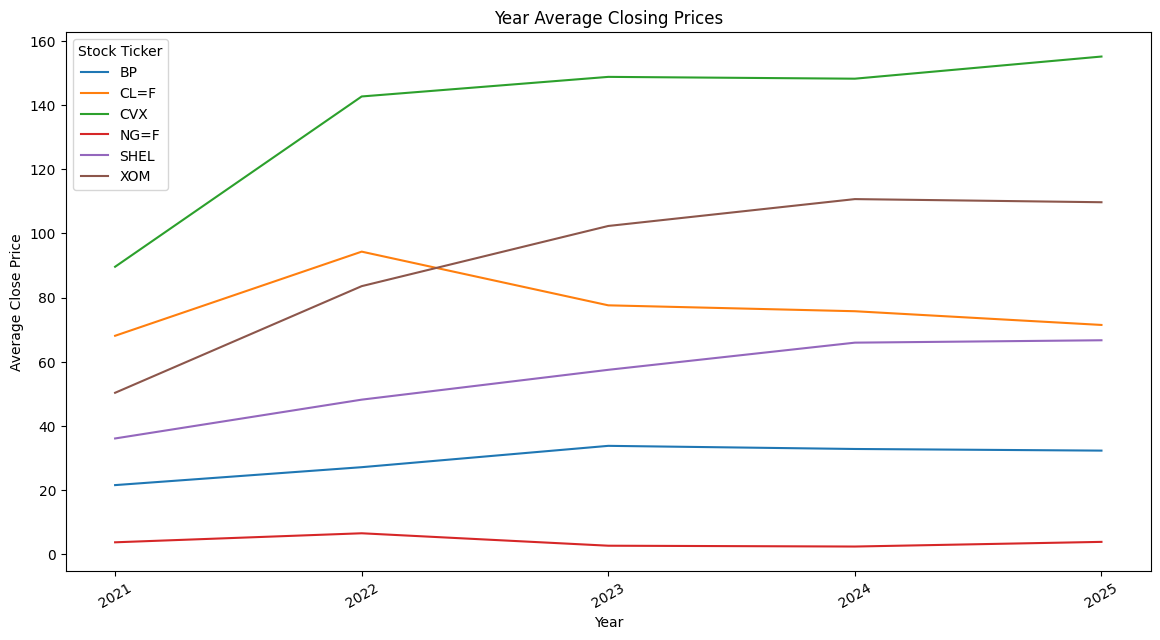

In [15]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.show()

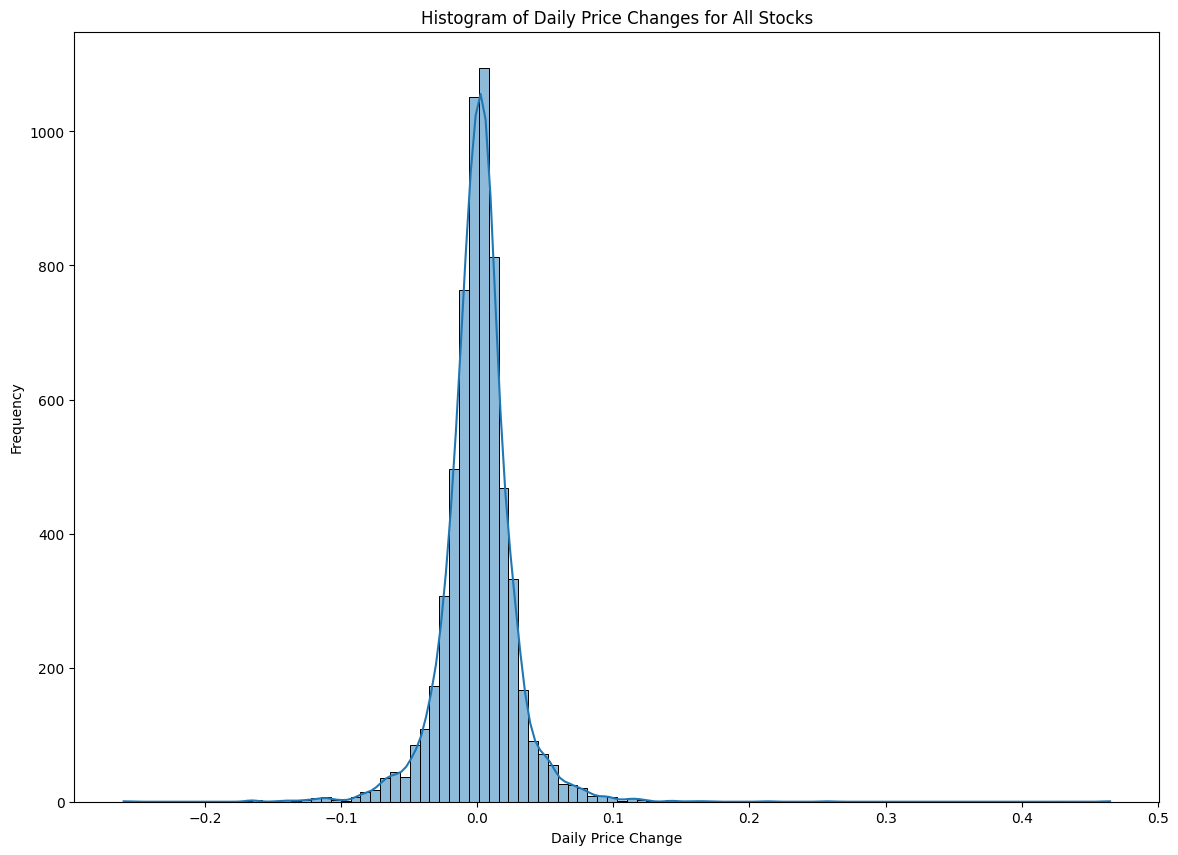

In [16]:
stock_data['price_change'] = stock_data.groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.show()

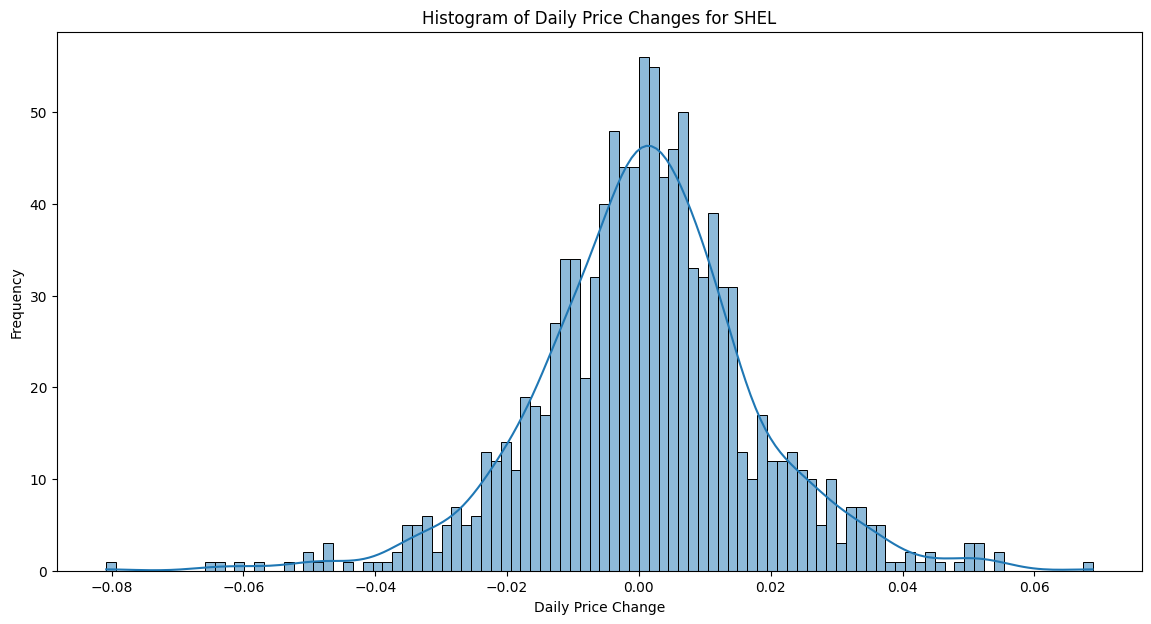

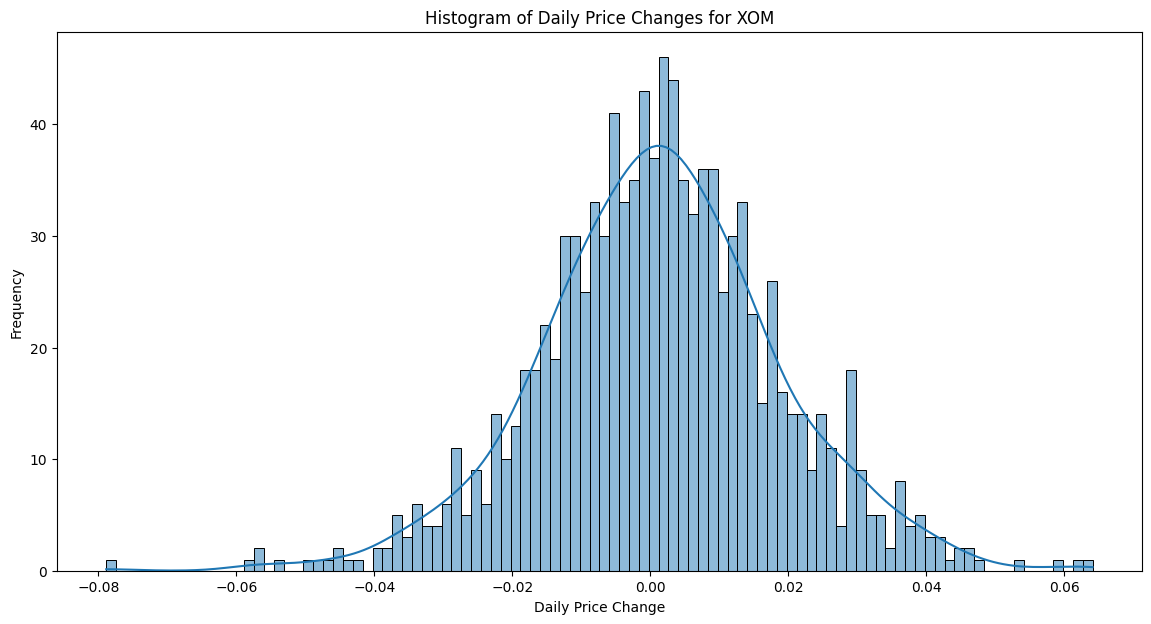

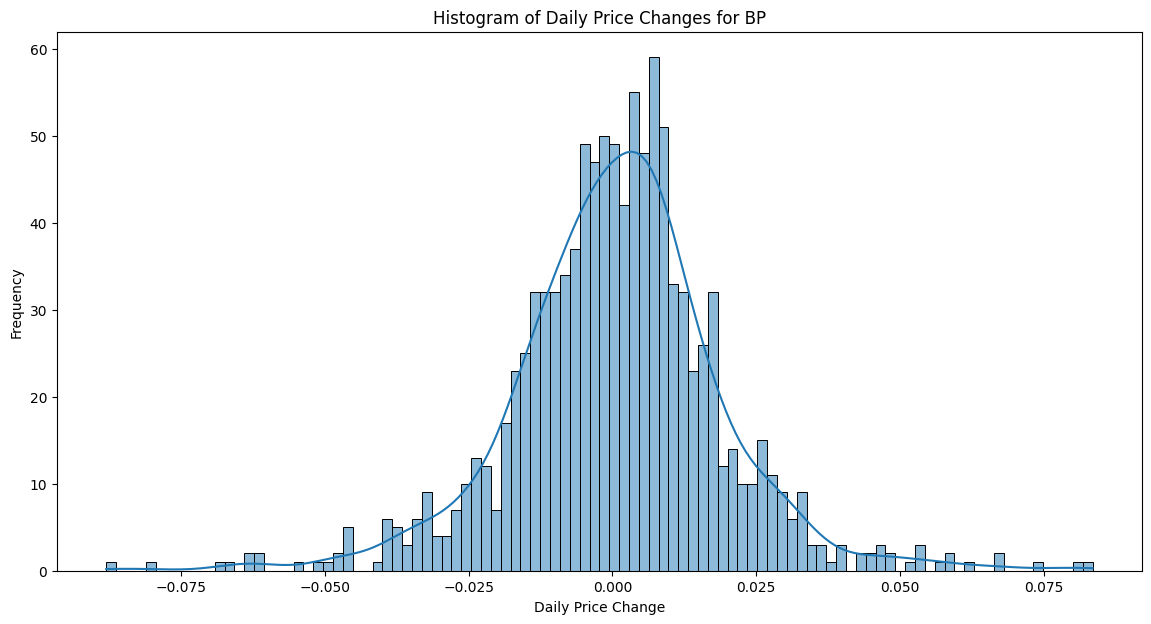

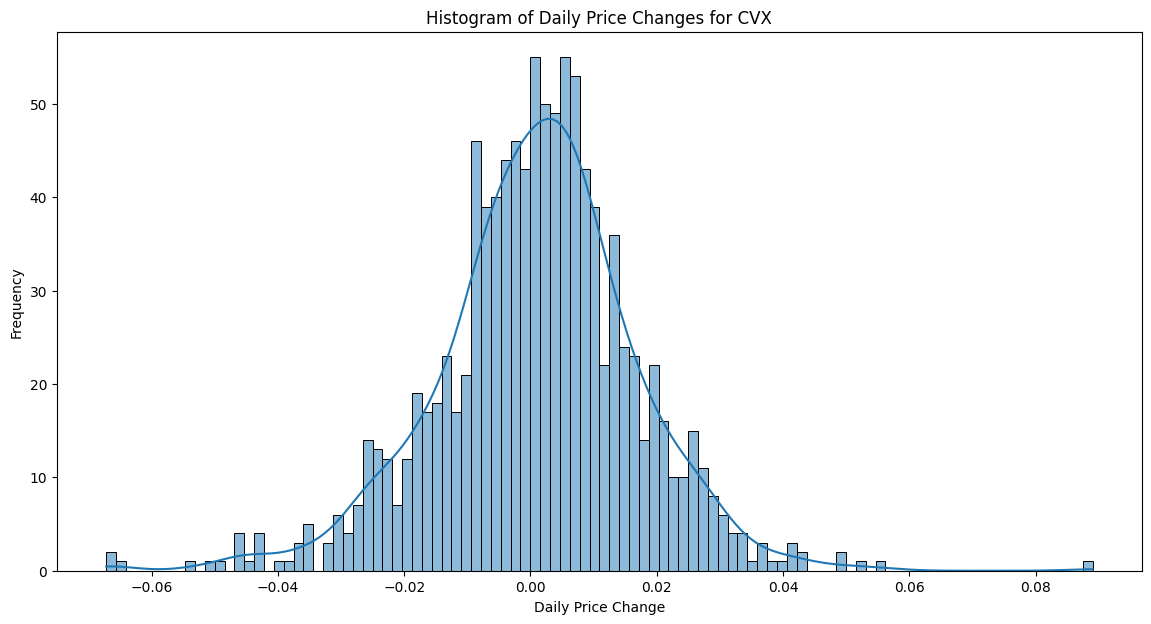

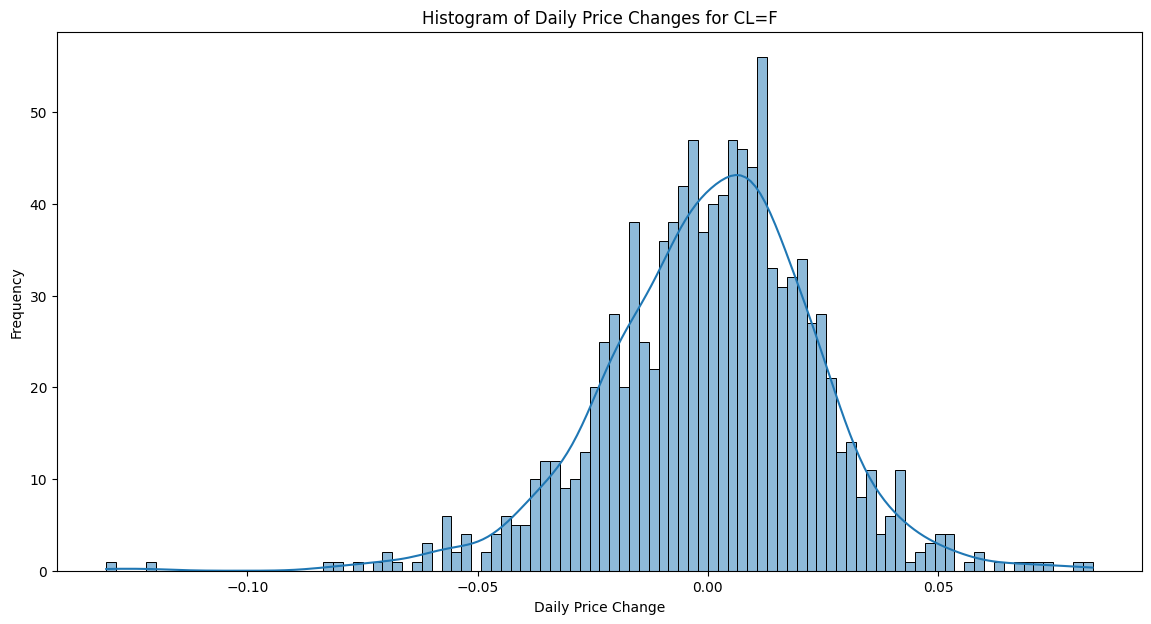

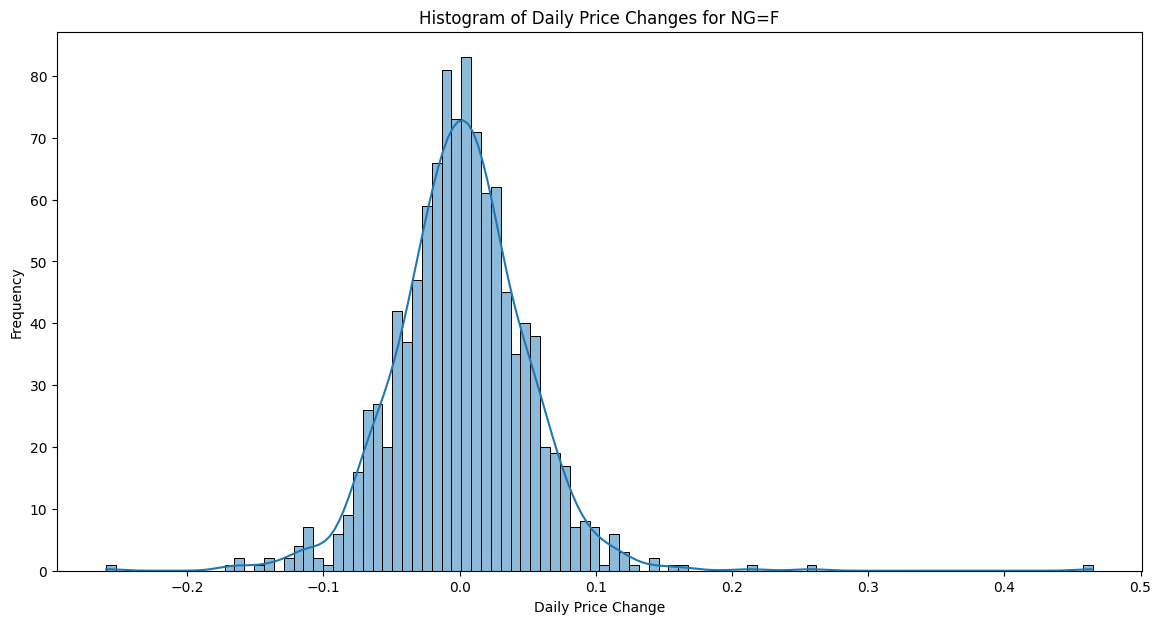

In [17]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.show()

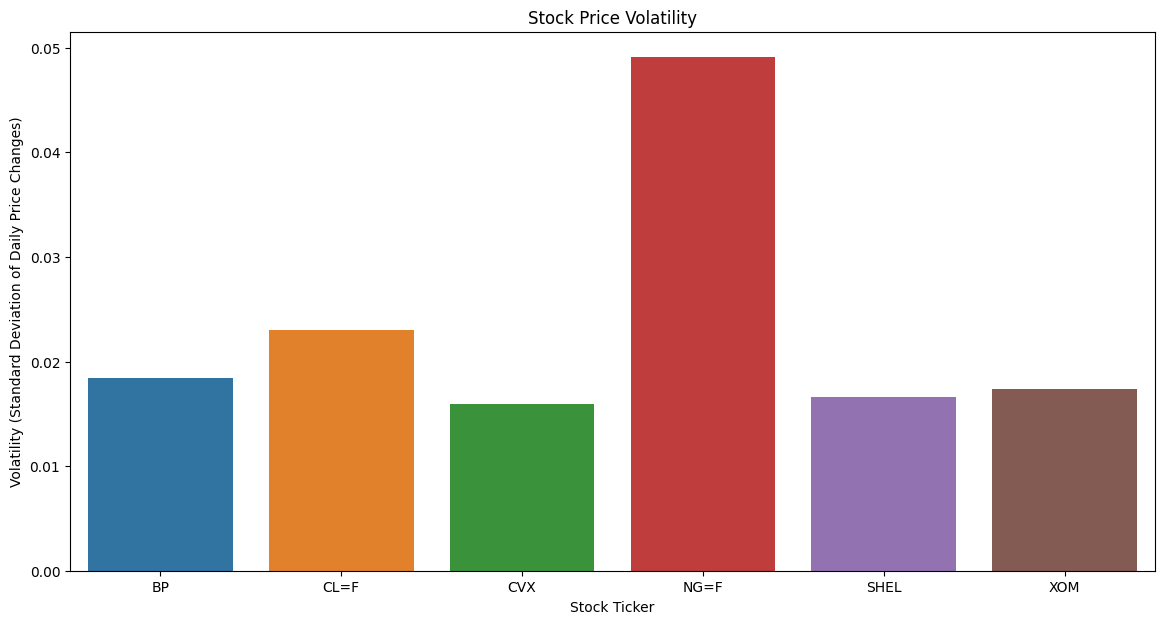

In [18]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.show()

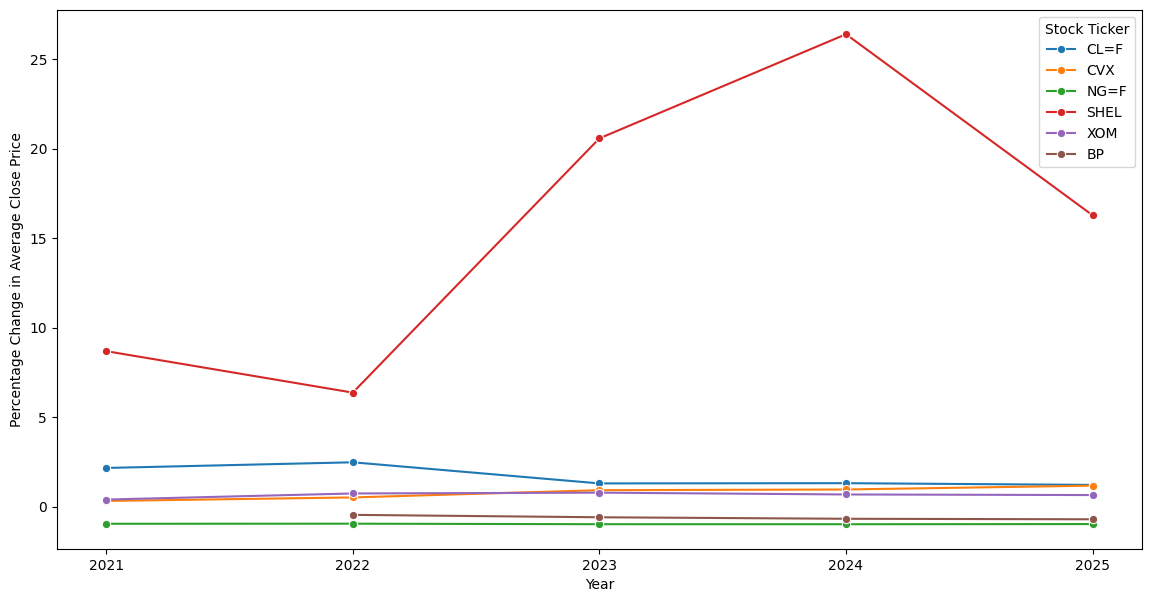

In [19]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.show()

## Shell

In [20]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

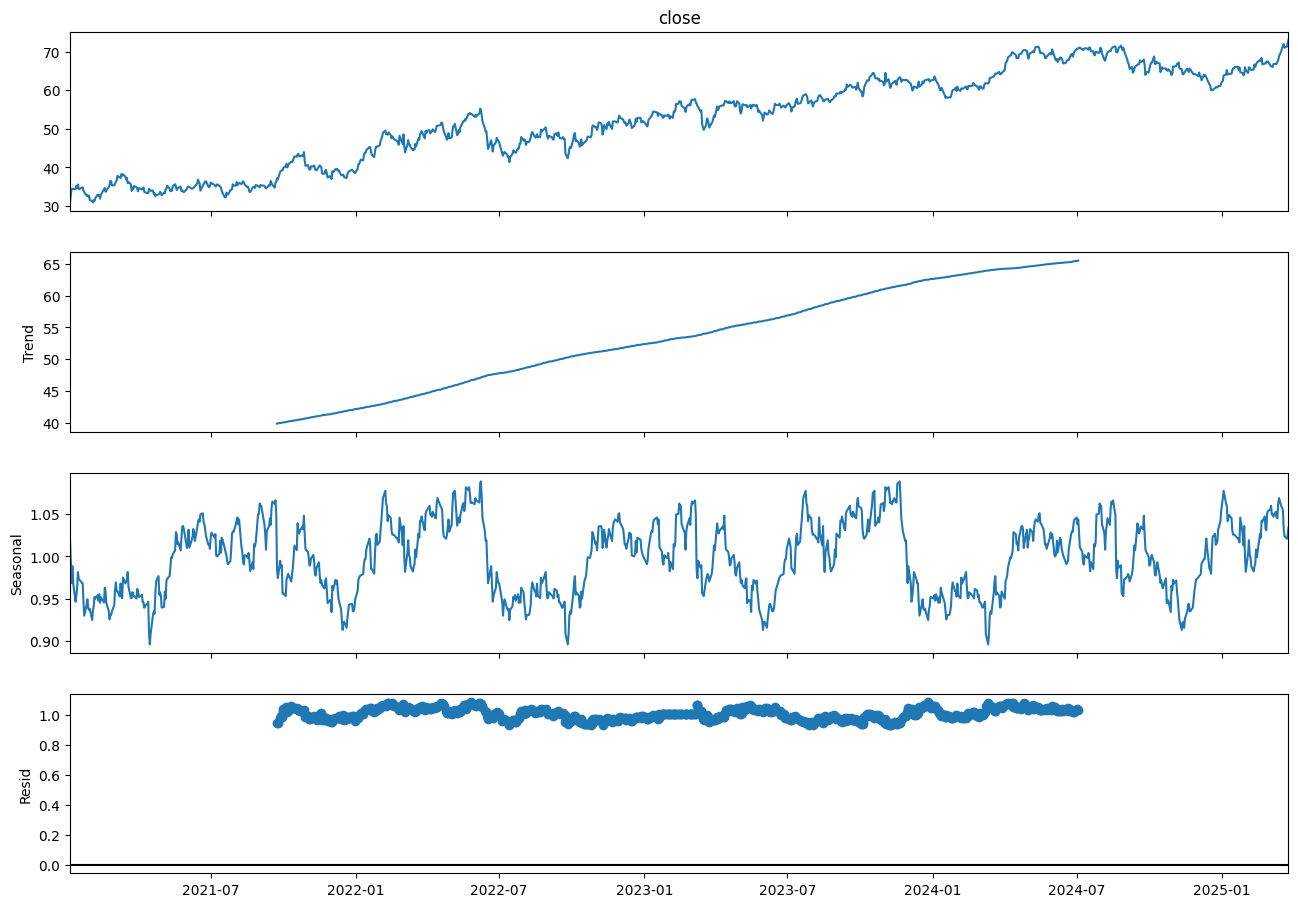

In [21]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

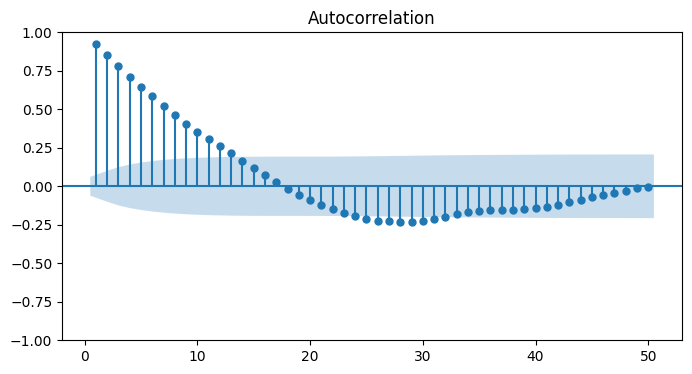

In [22]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

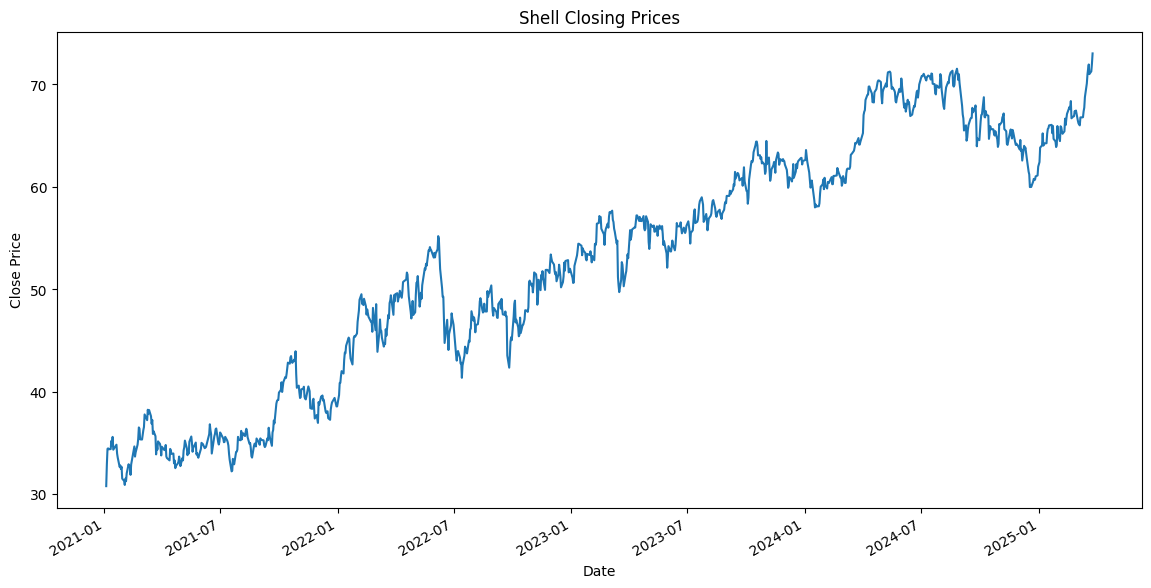

In [23]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_33388\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

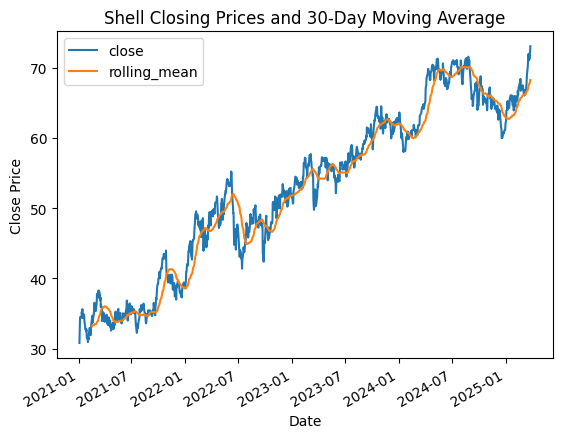

In [24]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [25]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

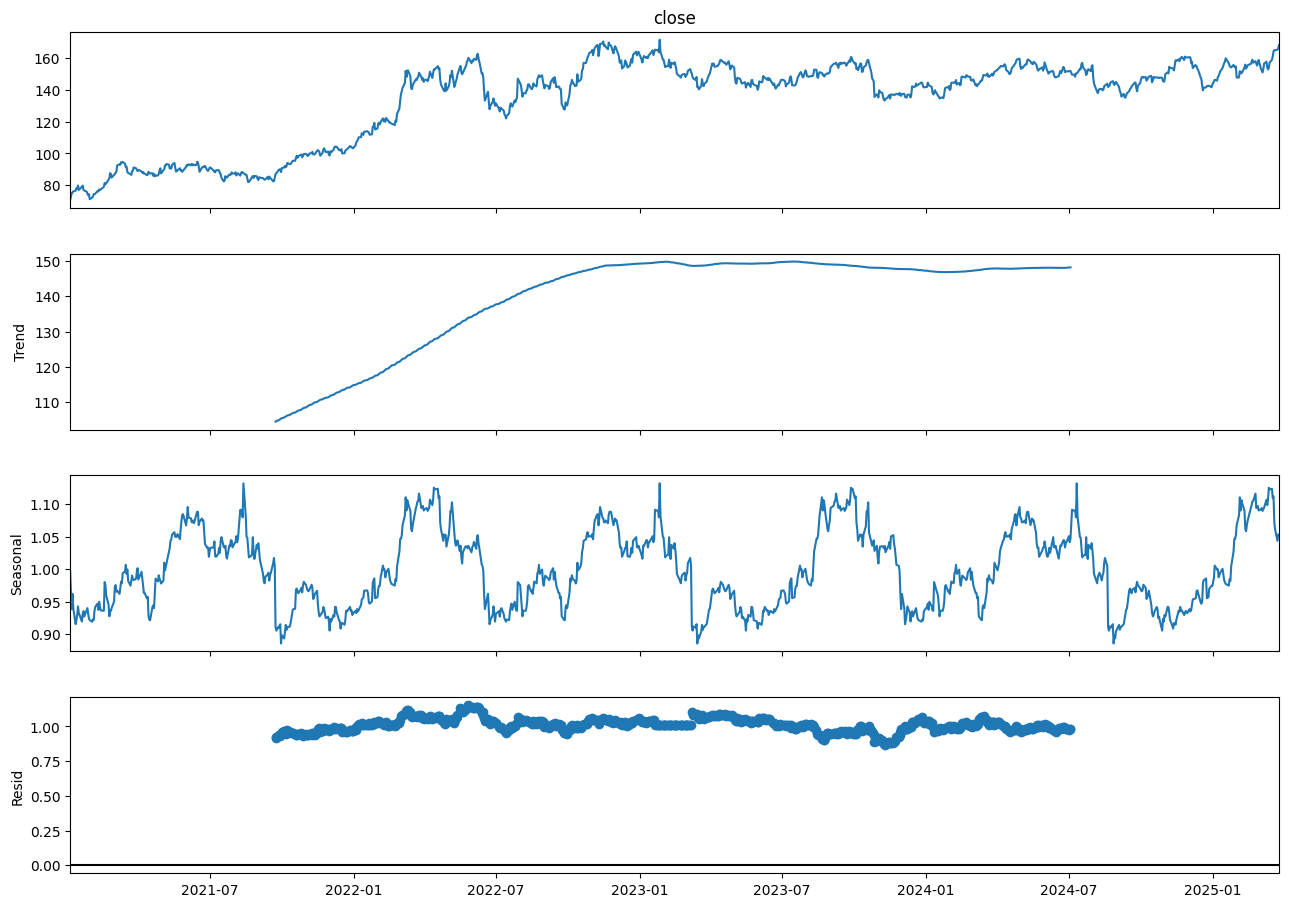

In [26]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

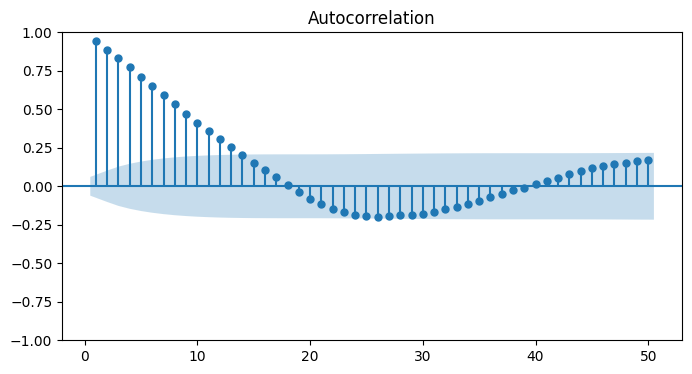

In [27]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

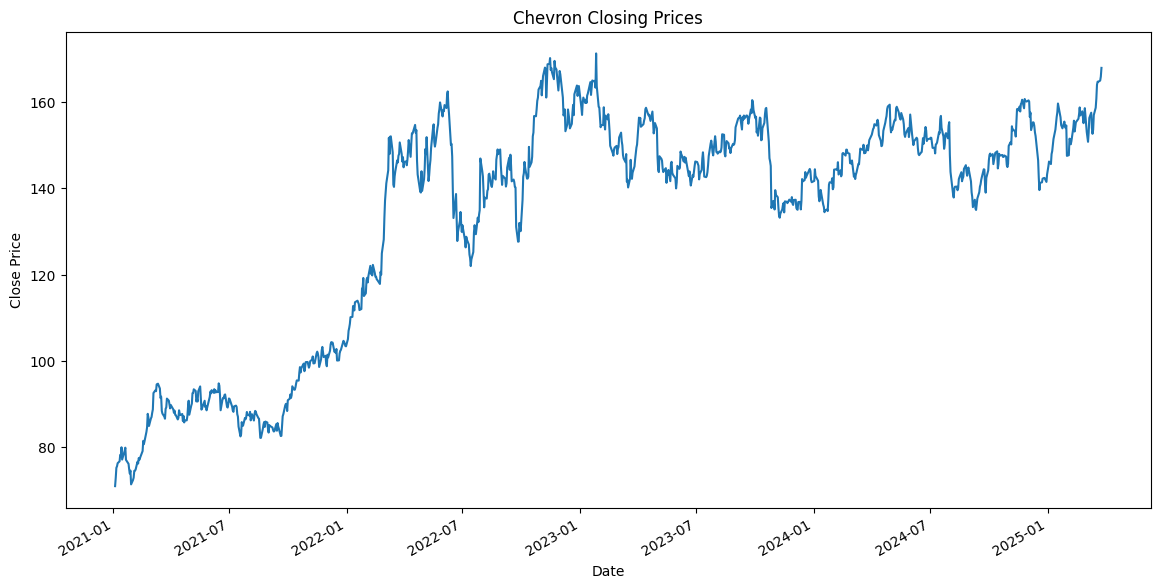

In [28]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_33388\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

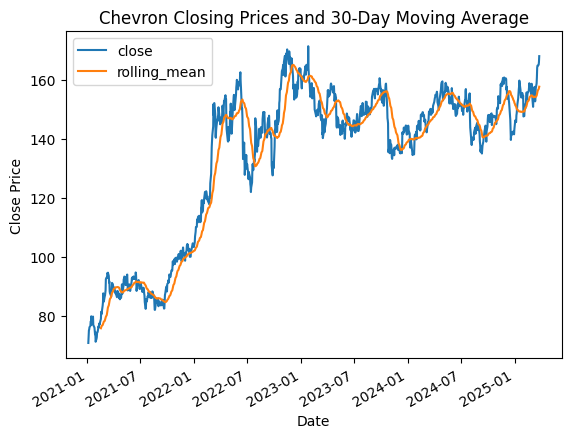

In [29]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ADF Test & PACF Plot & ACF Plot

adf test_p-value when d = 0: 0.6618078264062537
adf test_p-value when d = 1: 0.0
Final d = 1


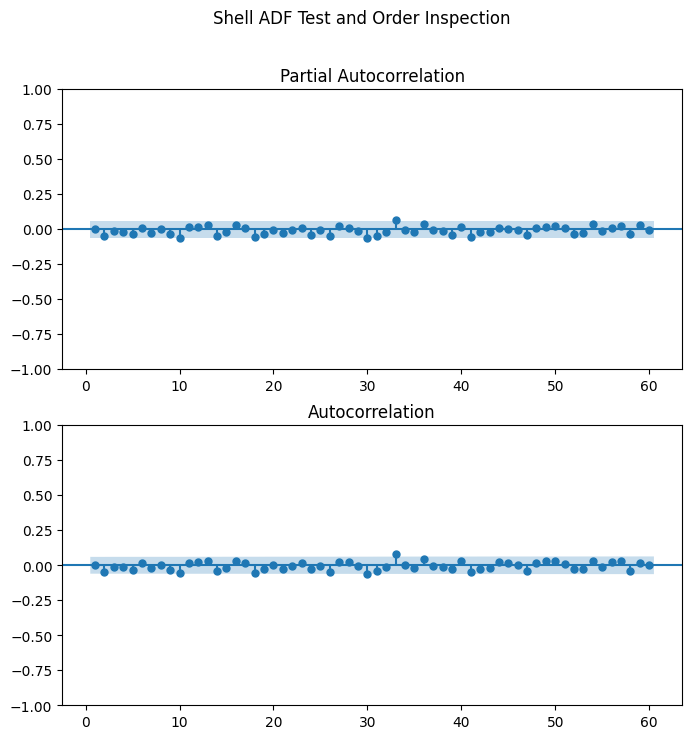

adf test_p-value when d = 0: 0.37907561009740715
adf test_p-value when d = 1: 0.0
Final d = 1


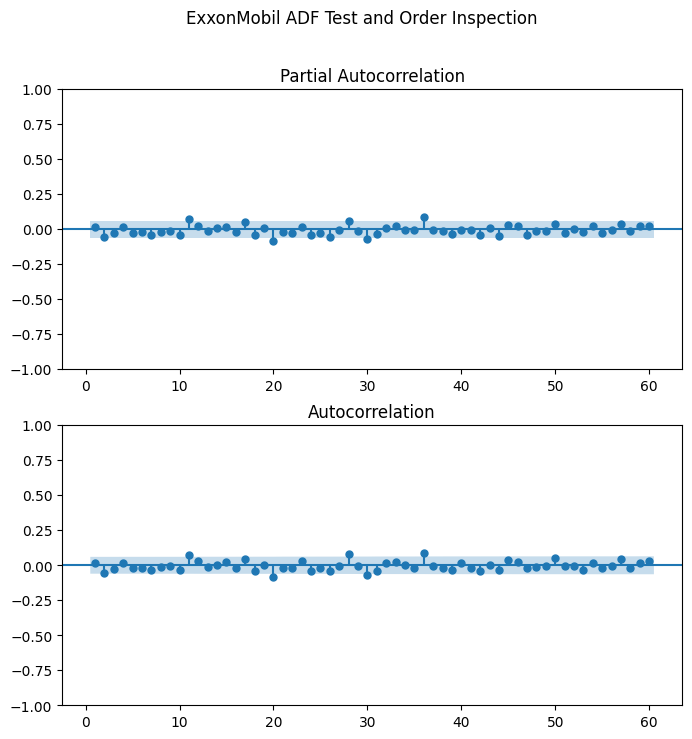

adf test_p-value when d = 0: 0.19102472343581828
adf test_p-value when d = 1: 0.0
Final d = 1


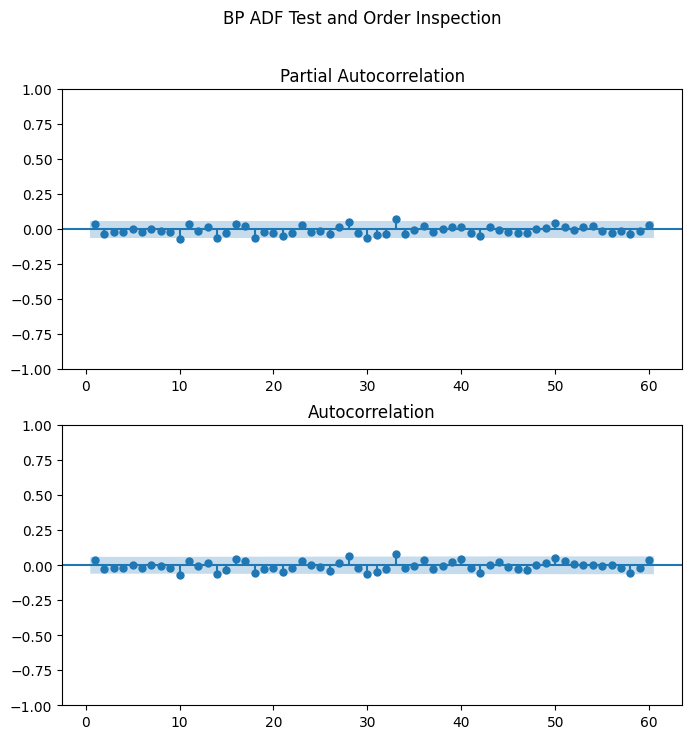

adf test_p-value when d = 0: 0.2749411858573717
adf test_p-value when d = 1: 0.0
Final d = 1


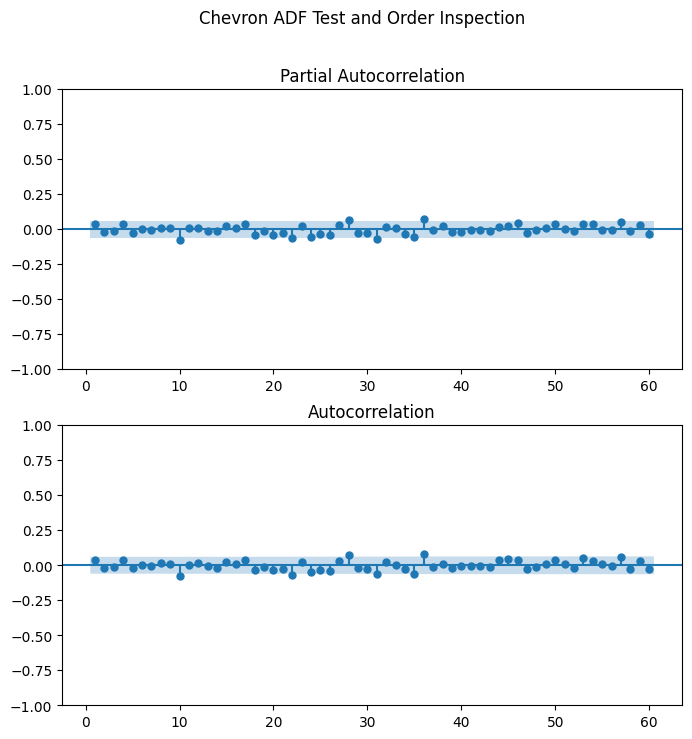

In [30]:
stock_data.set_index('date', inplace = True)

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

# Prediction

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1062
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1277.865
Date:                Thu, 27 Mar 2025   AIC                           2557.731
Time:                        10:32:24   BIC                           2562.698
Sample:                             0   HQIC                          2559.613
                               - 1062                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6511      0.021     30.400      0.000       0.609       0.693
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               123.32
Prob(Q):                              0.99   Pr

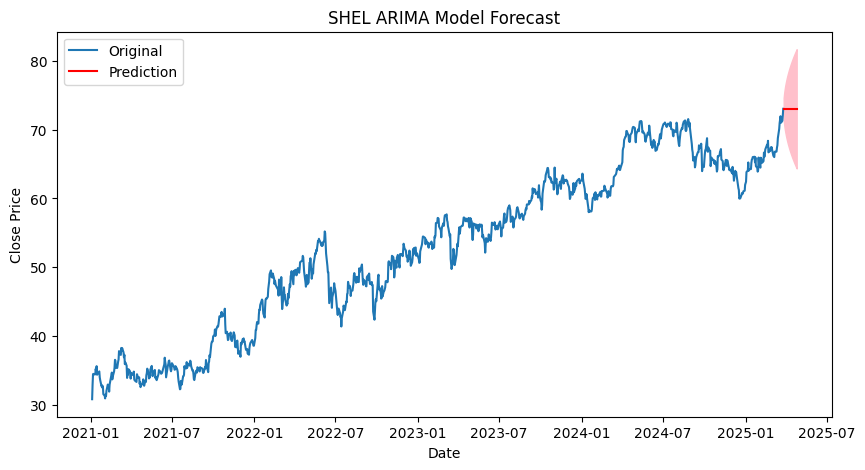

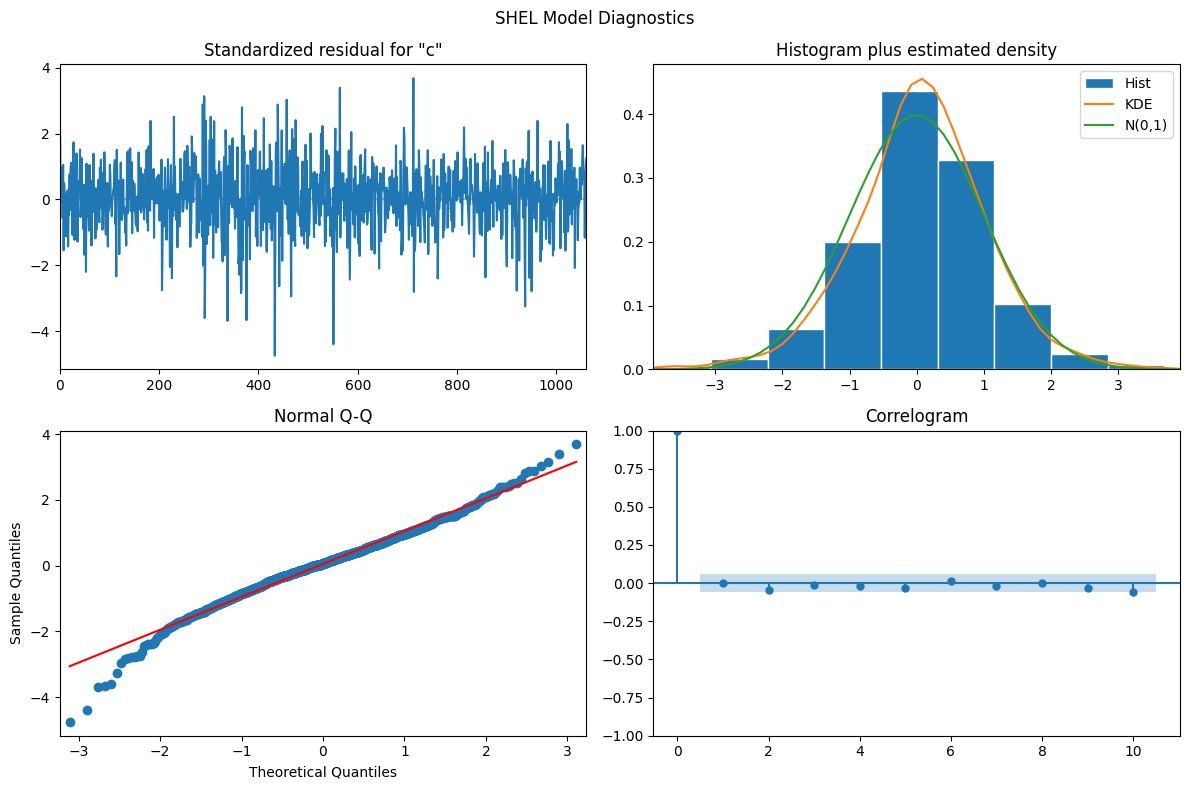

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1062
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1915.398
Date:                Thu, 27 Mar 2025   AIC                           3832.797
Time:                        10:32:25   BIC                           3837.764
Sample:                             0   HQIC                          3834.679
                               - 1062                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1655      0.076     28.552      0.000       2.017       2.314
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                62.54
Prob(Q):                              0.54   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

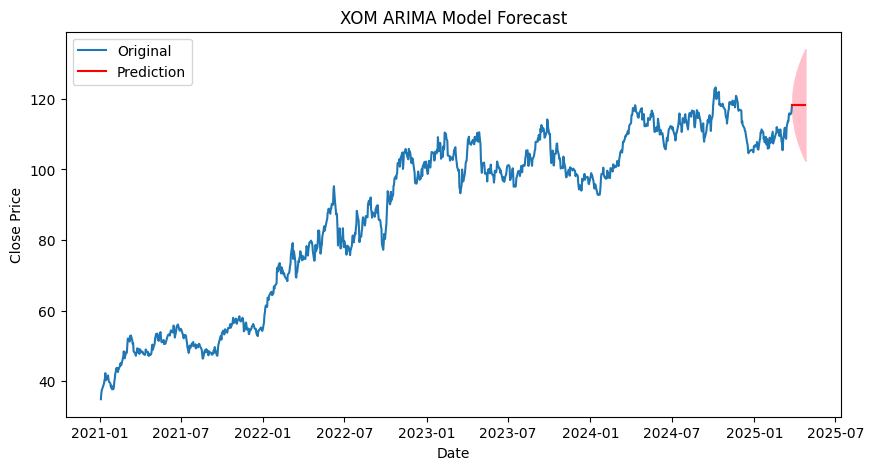

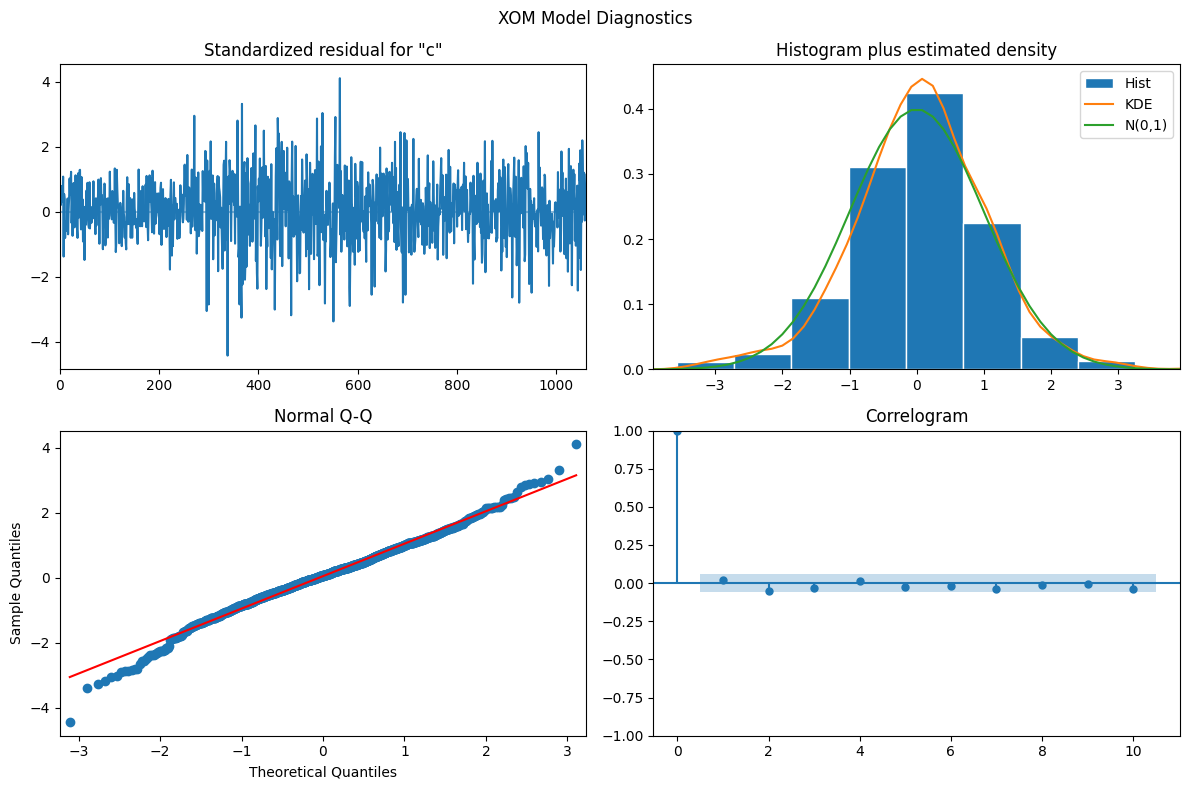

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1062
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -778.661
Date:                Thu, 27 Mar 2025   AIC                           1559.322
Time:                        10:32:25   BIC                           1564.289
Sample:                             0   HQIC                          1561.204
                               - 1062                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2541      0.007     37.368      0.000       0.241       0.267
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):               496.92
Prob(Q):                              0.22   Pr

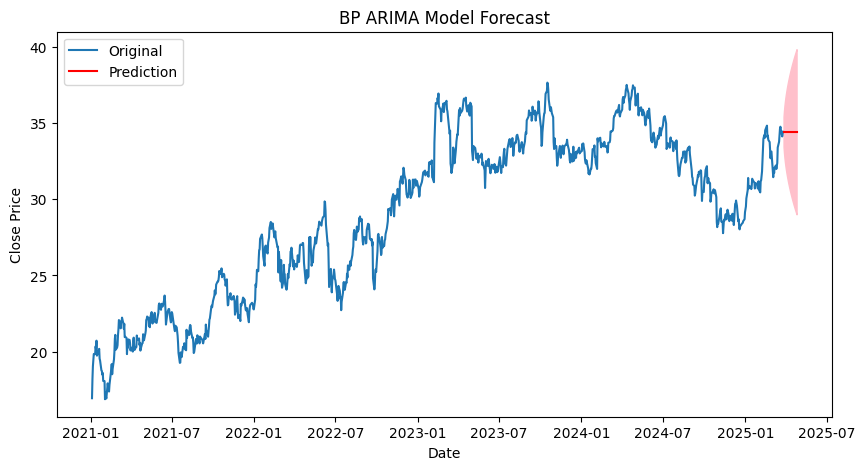

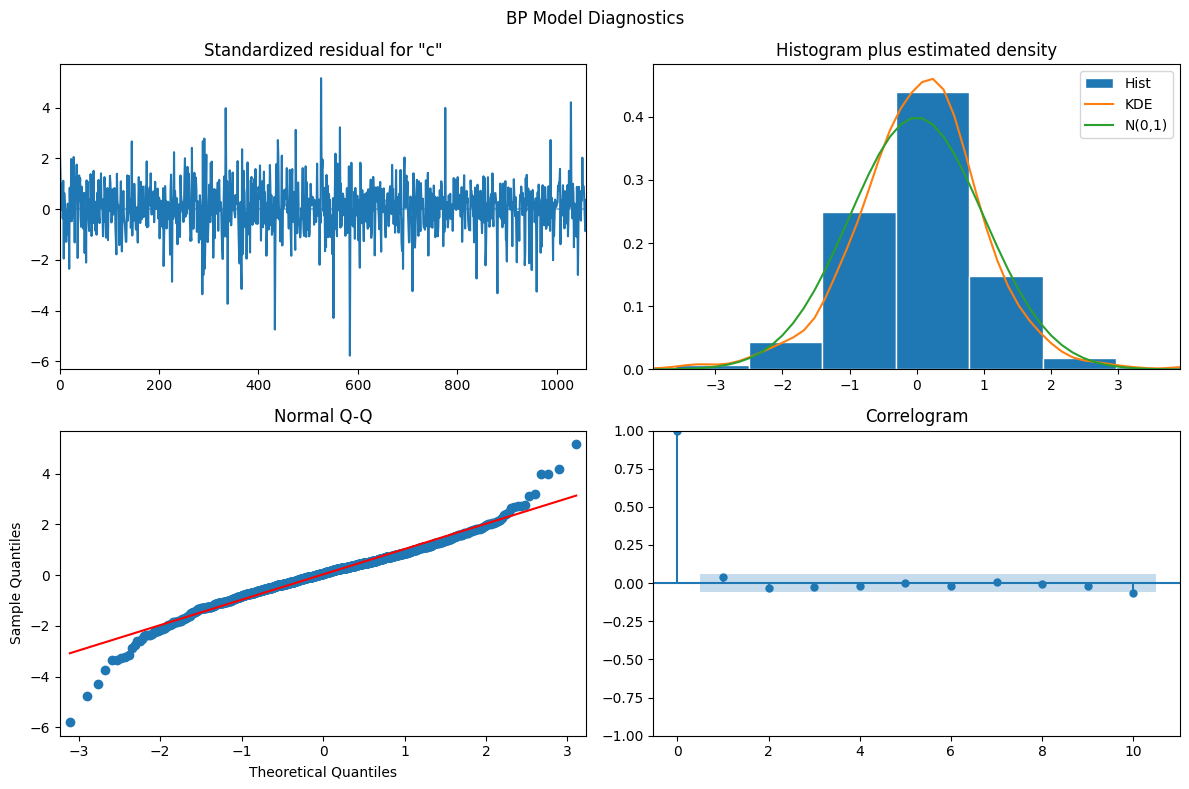

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1062
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2320.640
Date:                Thu, 27 Mar 2025   AIC                           4643.280
Time:                        10:32:26   BIC                           4648.247
Sample:                             0   HQIC                          4645.162
                               - 1062                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.6486      0.130     35.676      0.000       4.393       4.904
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):               388.07
Prob(Q):                              0.19   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

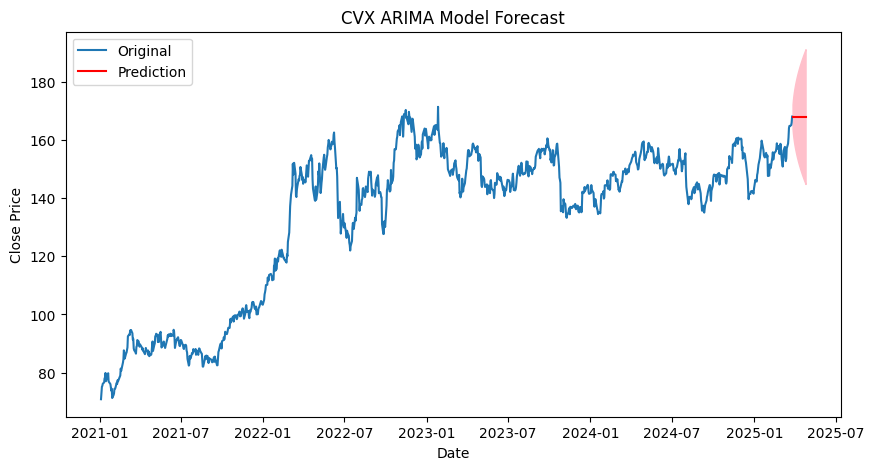

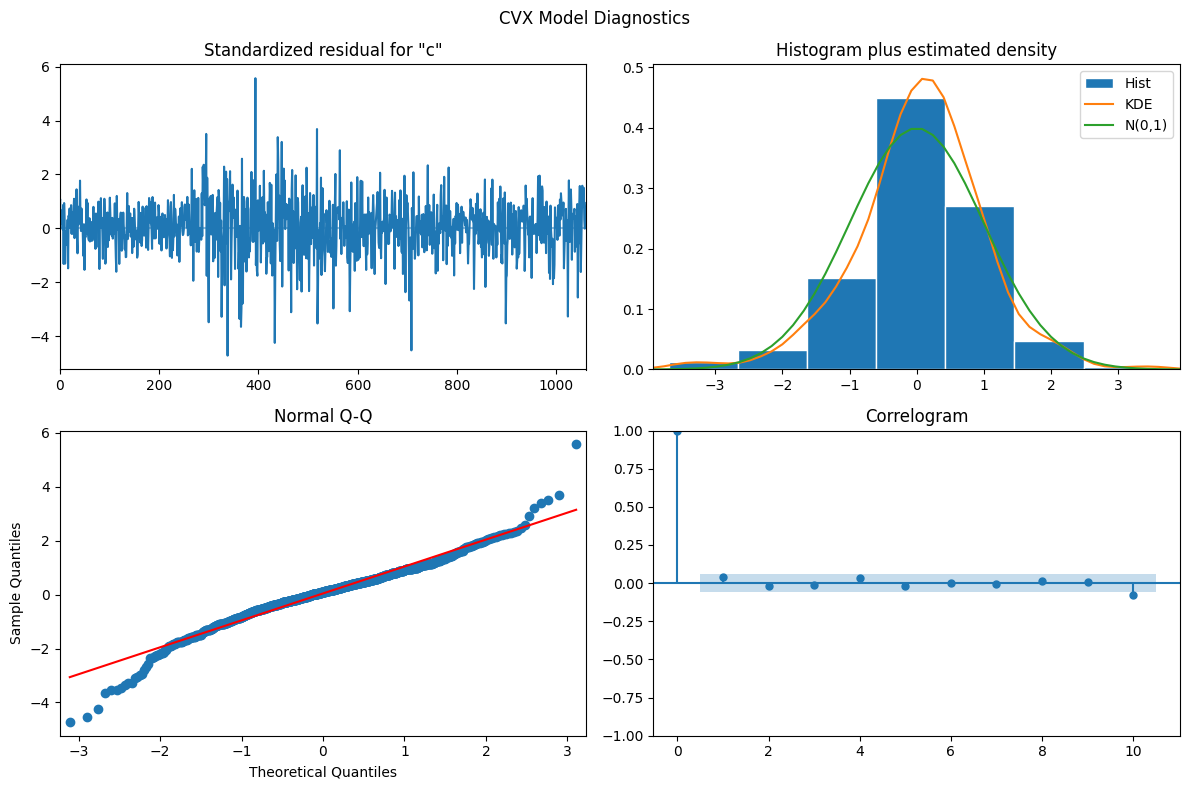

In [31]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






## Prediction with Train Test Split

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1032.492
Date:                Thu, 27 Mar 2025   AIC                           2066.983
Time:                        10:32:51   BIC                           2071.726
Sample:                             0   HQIC                          2068.800
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6685      0.024     27.683      0.000       0.621       0.716
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               110.62
Prob(Q):                  

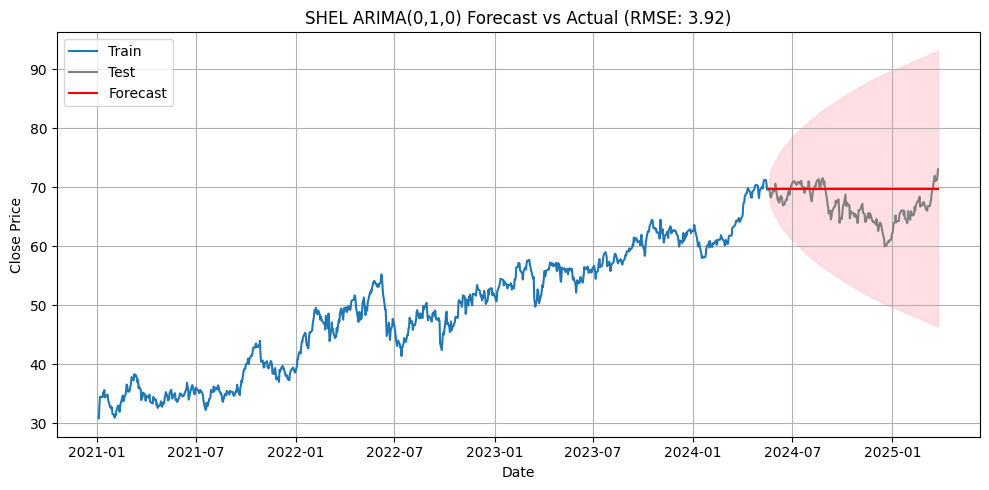

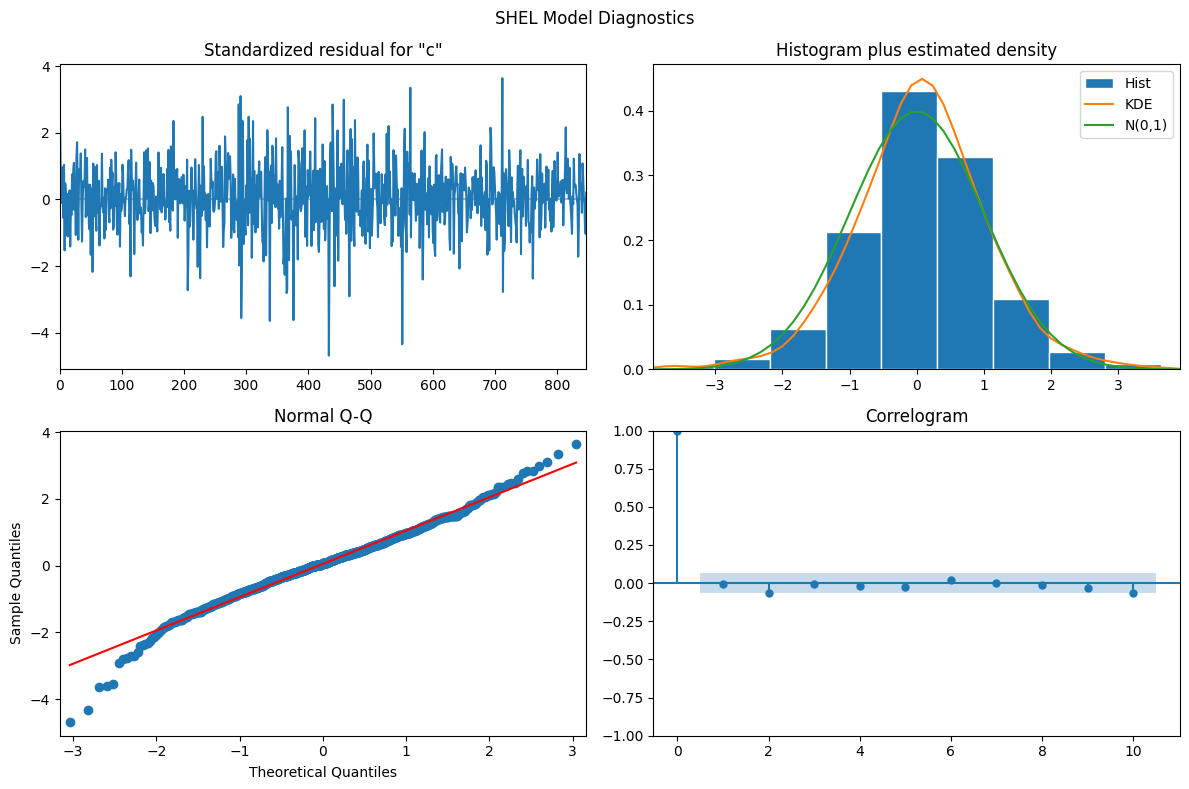

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1529.736
Date:                Thu, 27 Mar 2025   AIC                           3061.472
Time:                        10:32:52   BIC                           3066.215
Sample:                             0   HQIC                          3063.289
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1597      0.081     26.664      0.000       2.001       2.318
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                76.78
Prob(Q):                   

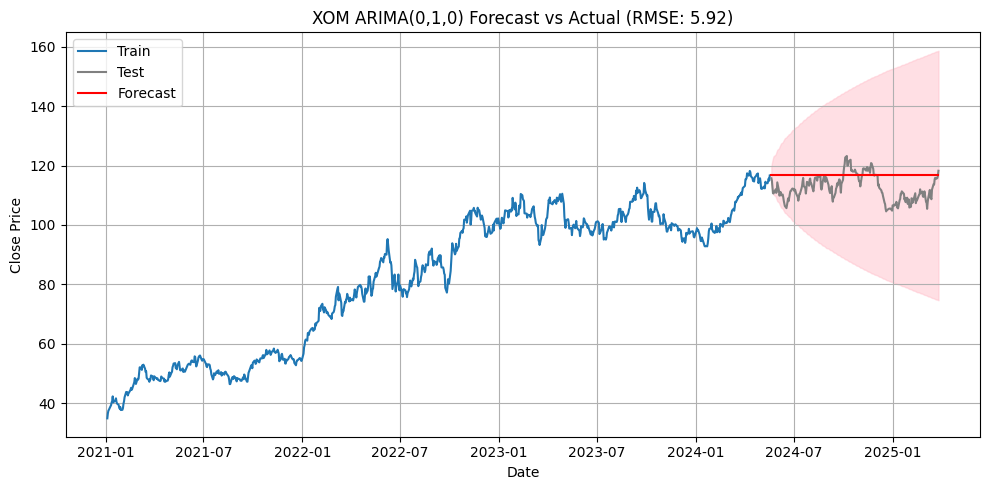

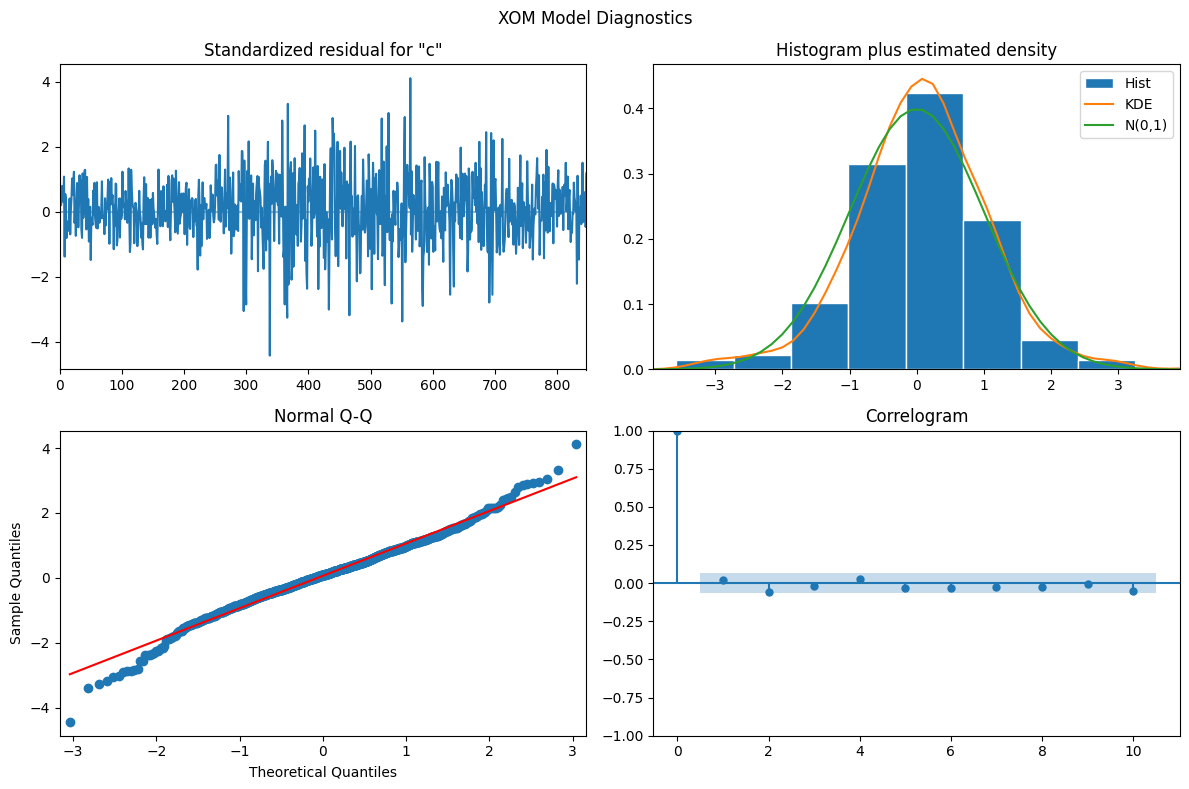

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -636.594
Date:                Thu, 27 Mar 2025   AIC                           1275.188
Time:                        10:32:52   BIC                           1279.931
Sample:                             0   HQIC                          1277.005
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2628      0.008     33.506      0.000       0.247       0.278
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               408.60
Prob(Q):                    

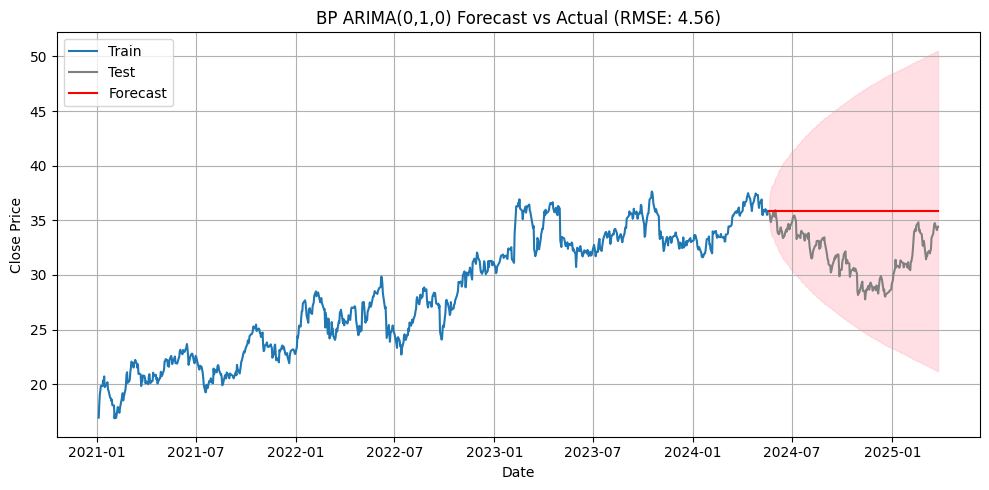

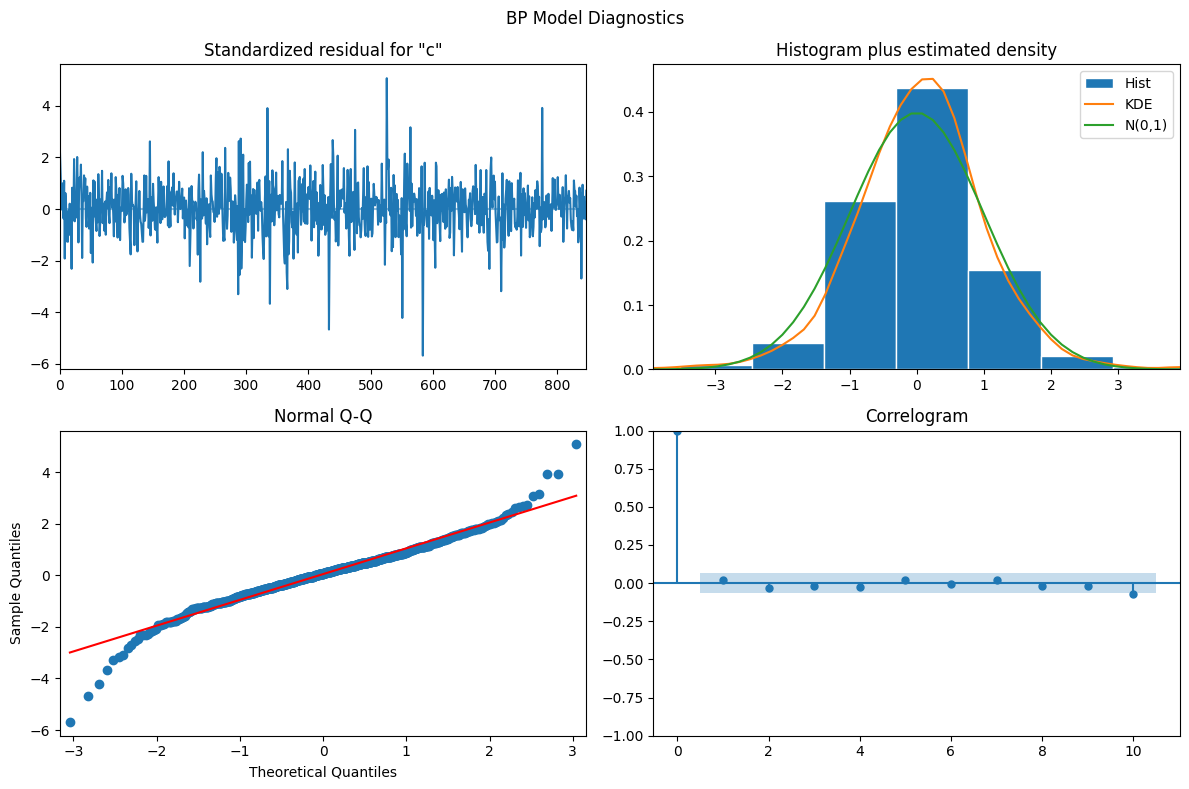

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1872.733
Date:                Thu, 27 Mar 2025   AIC                           3747.467
Time:                        10:32:53   BIC                           3752.210
Sample:                             0   HQIC                          3749.284
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.8498      0.149     32.577      0.000       4.558       5.142
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               348.19
Prob(Q):                   

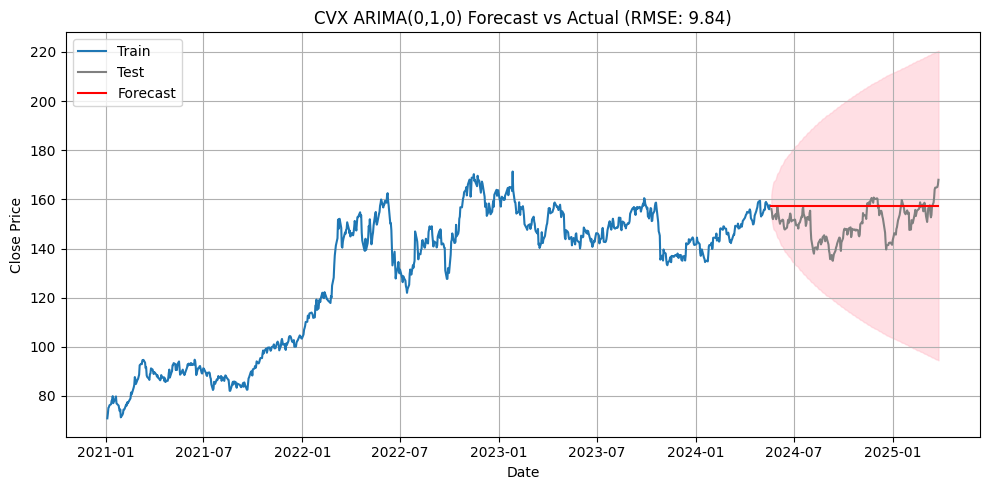

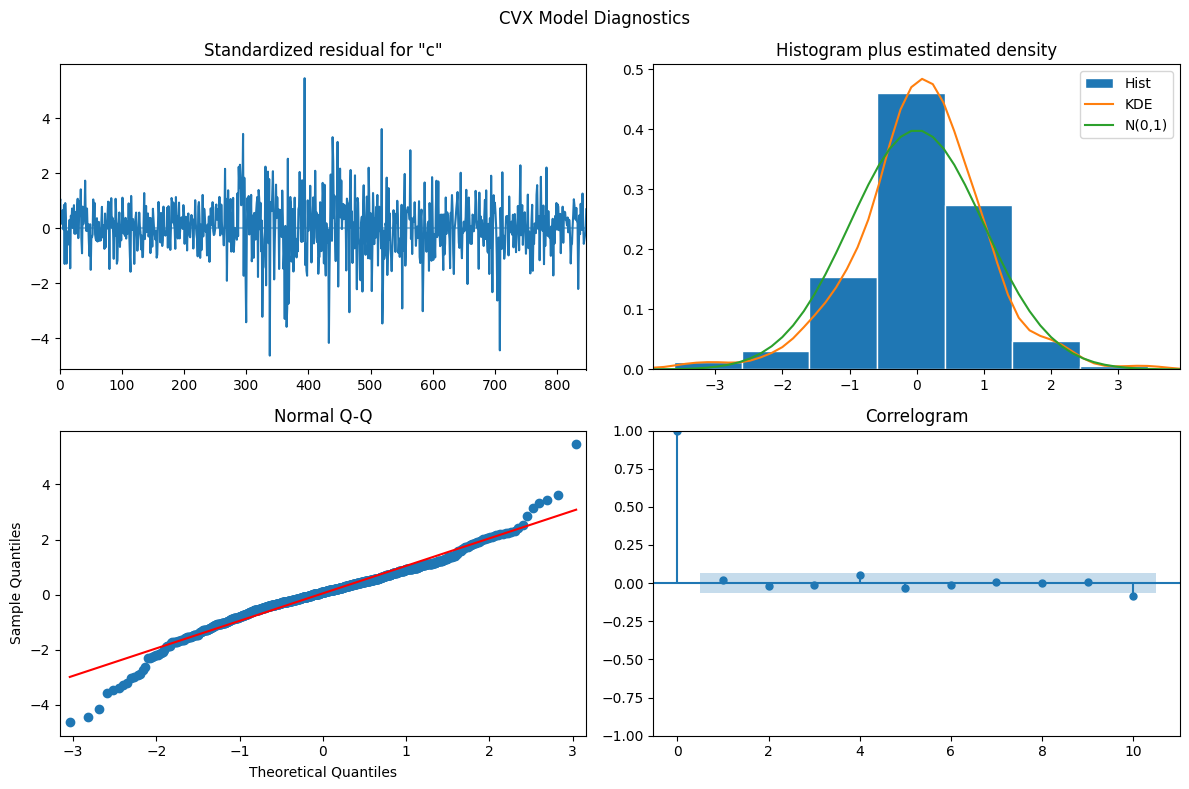

In [ ]:
for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(0, 1, 0))
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()

## Prediction with Crude Oil Price Data

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -893.647
Date:                Thu, 27 Mar 2025   AIC                           1791.294
Time:                        10:33:26   BIC                           1800.780
Sample:                             0   HQIC                          1794.928
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2073      0.007     27.710      0.000       0.193       0.222
sigma2         0.4818      0.016     29.622      0.000       0.450       0.514
Ljung-Box (L1) (Q):            

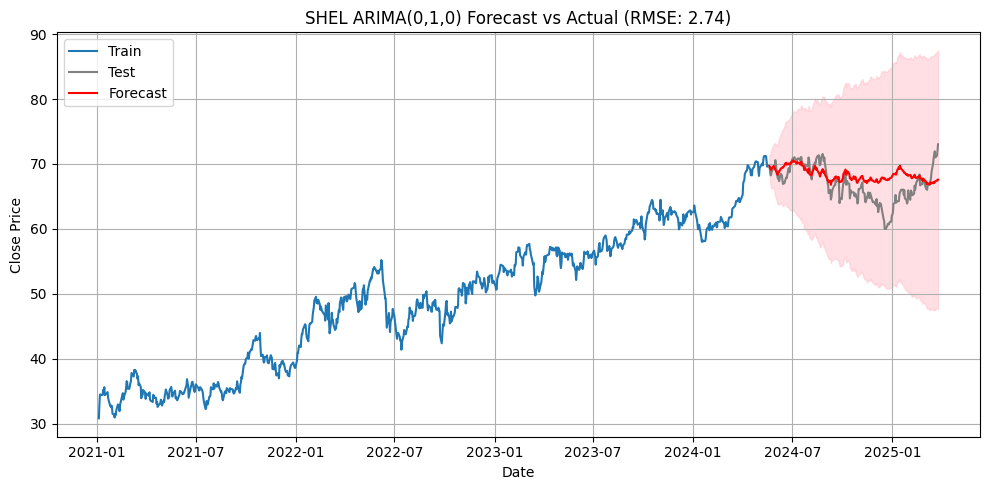

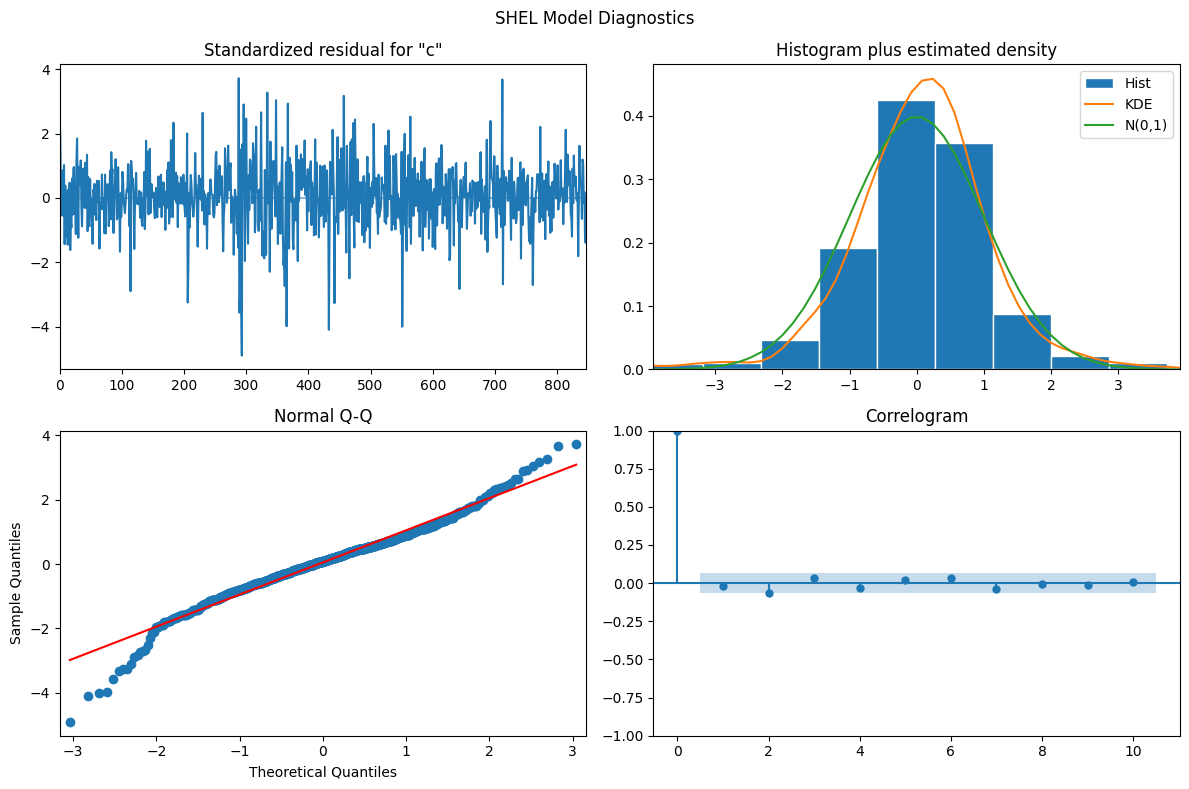

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1340.840
Date:                Thu, 27 Mar 2025   AIC                           2685.679
Time:                        10:33:27   BIC                           2695.165
Sample:                             0   HQIC                          2689.313
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4228      0.015     28.332      0.000       0.394       0.452
sigma2         1.3833      0.053     26.348      0.000       1.280       1.486
Ljung-Box (L1) (Q):             

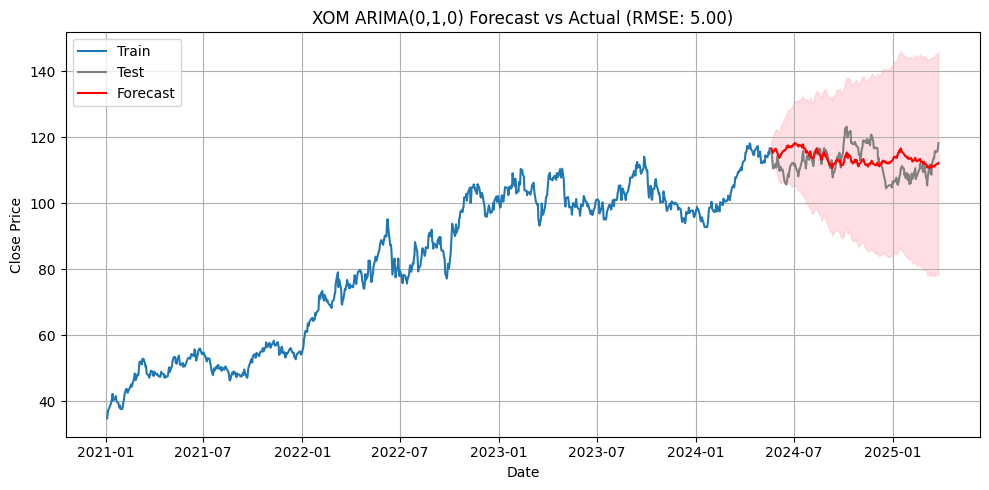

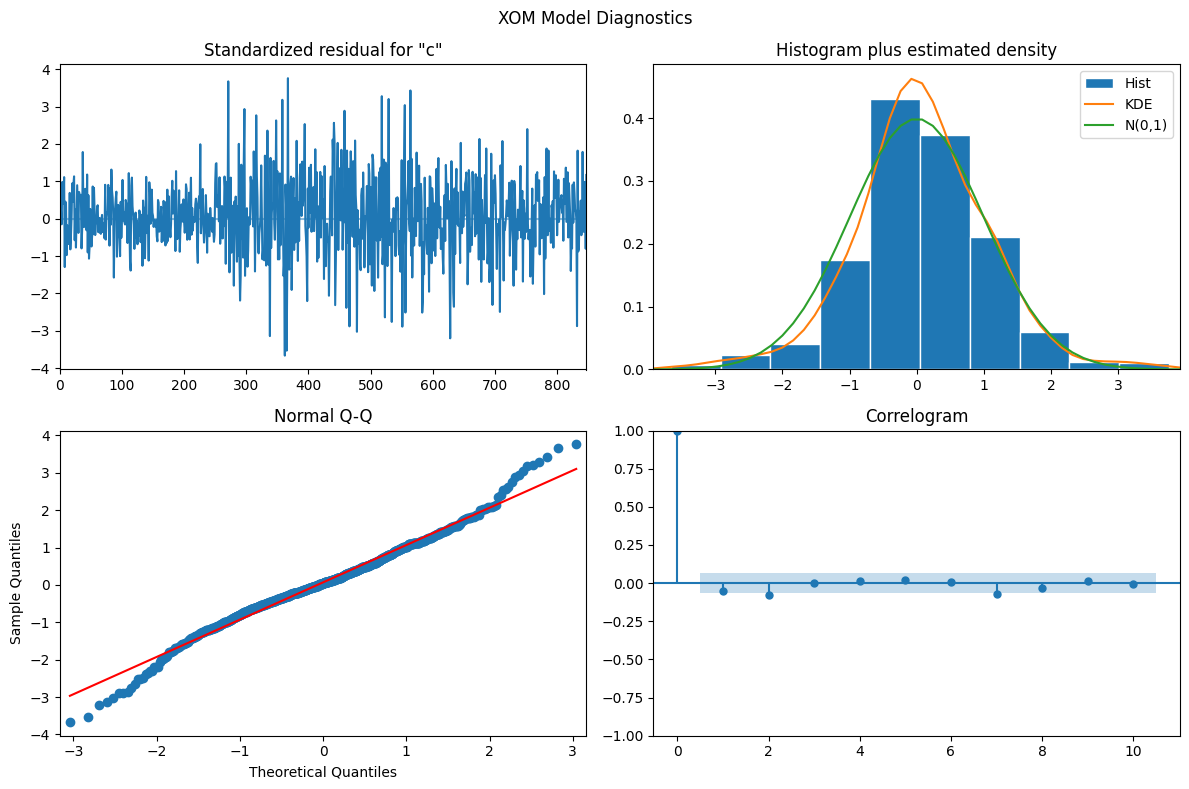

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -500.948
Date:                Thu, 27 Mar 2025   AIC                           1005.896
Time:                        10:33:28   BIC                           1015.382
Sample:                             0   HQIC                          1009.530
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.1287      0.005     27.648      0.000       0.120       0.138
sigma2         0.1908      0.005     37.462      0.000       0.181       0.201
Ljung-Box (L1) (Q):              

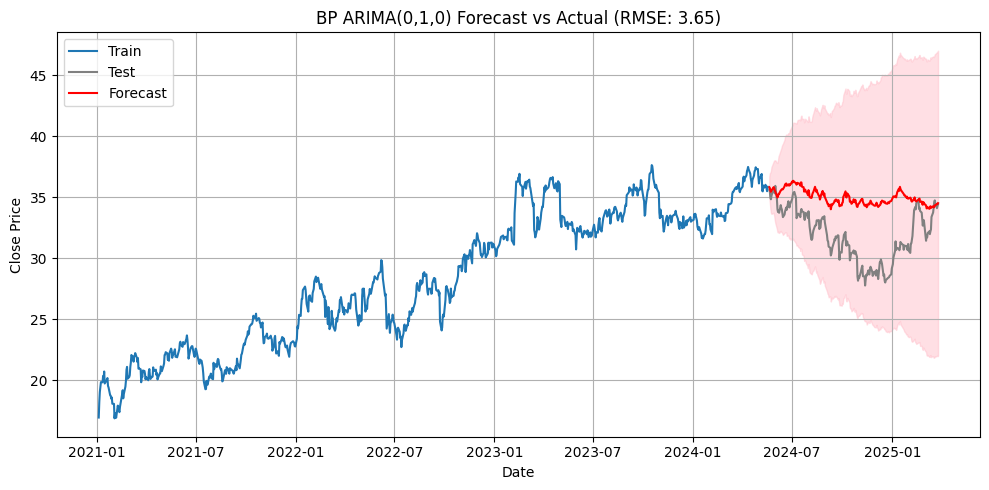

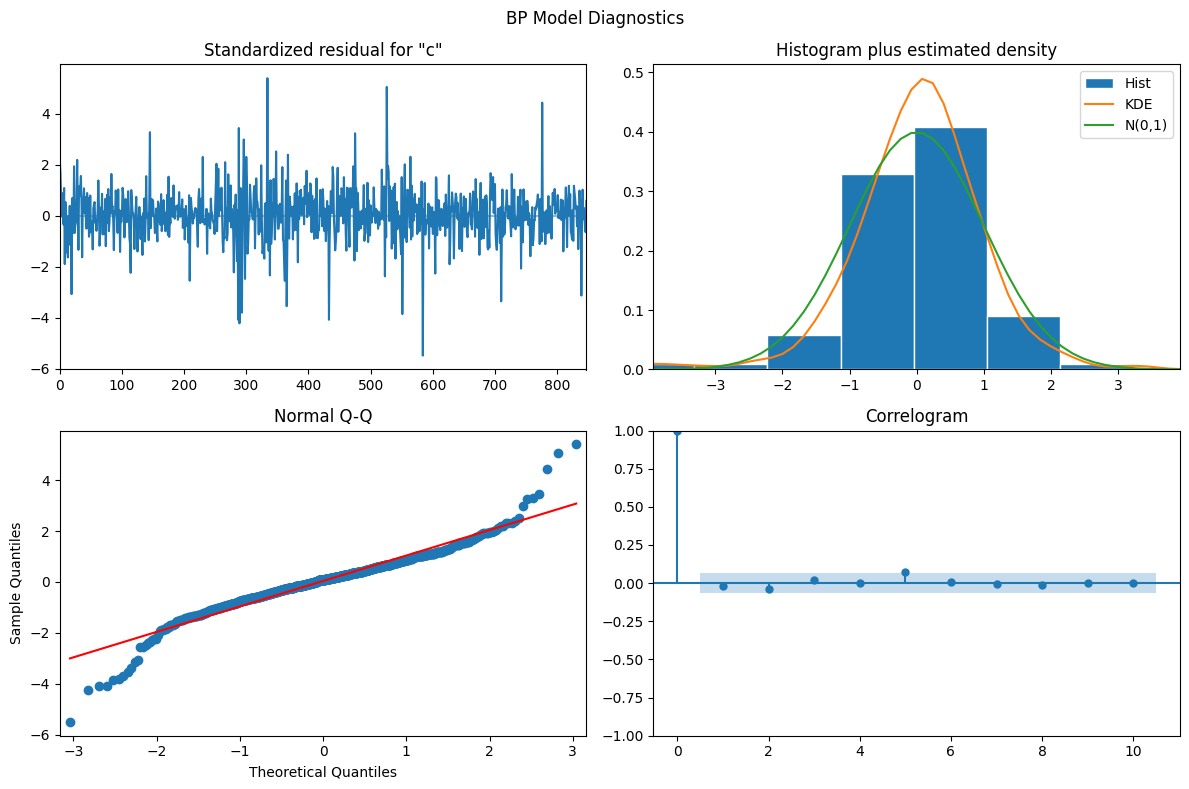

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  849
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1721.256
Date:                Thu, 27 Mar 2025   AIC                           3446.512
Time:                        10:33:28   BIC                           3455.998
Sample:                             0   HQIC                          3450.146
                                - 849                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.5792      0.022     26.289      0.000       0.536       0.622
sigma2         3.3929      0.090     37.653      0.000       3.216       3.569
Ljung-Box (L1) (Q):             

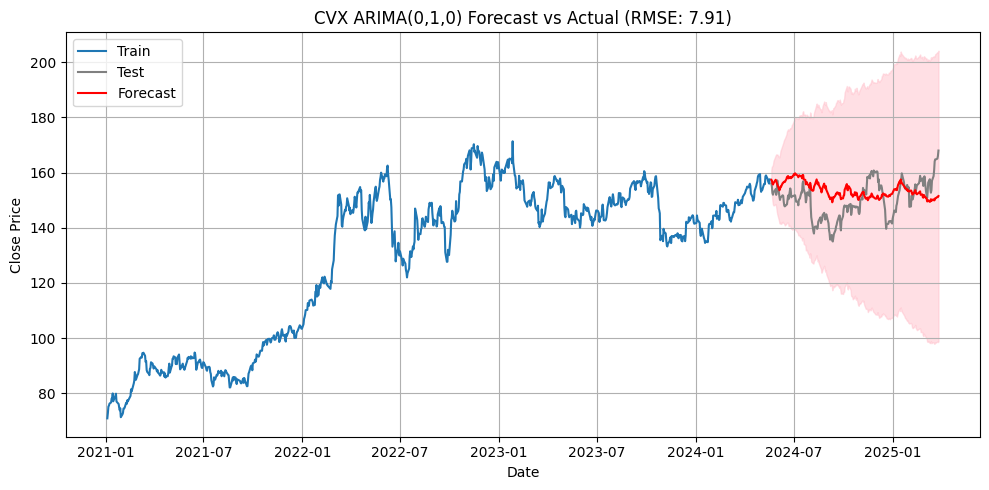

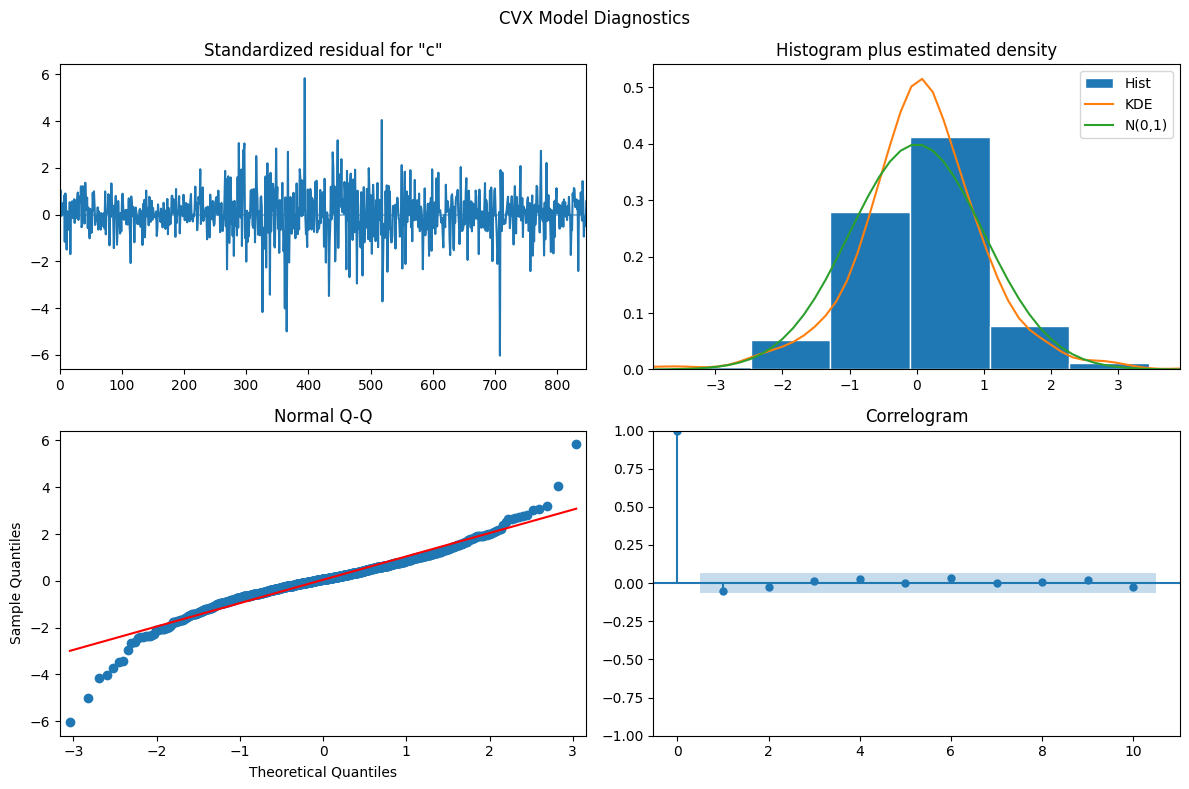

In [34]:
for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='CL=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()